In [39]:
import torch
import torchvision
import torch.optim as optim
from torchsummary import summary

from dataloader import get_CIFAR10dataset, CIFAR10_dataset, get_transforms, get_dataloader
from model import Net
from train import train_epoch, test_epoch
from utils import show_samples

# Set Global Config

In [40]:
SEED = 1

# CUDA?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA Available?", device)

# For reproducibility
torch.manual_seed(SEED)

if device=='cuda':
    torch.cuda.manual_seed(SEED)

CUDA Available? cuda


# Get the data 

In [41]:
train_data = get_CIFAR10dataset(root="./data", train_flag=True, download_flag=True)
test_data = get_CIFAR10dataset(root="./data", train_flag=False, download_flag=True)

Files already downloaded and verified
Files already downloaded and verified


# Create CIFAR10- Dataset

In [42]:
train_tfms = get_transforms(basic=True)
test_tfms = get_transforms(basic=True)

In [43]:
train_ds = CIFAR10_dataset(data=train_data.data, targets=train_data.targets, transforms=train_tfms)
test_ds = CIFAR10_dataset(data=test_data.data, targets=test_data.targets, transforms=test_tfms)

# Create DataLoader

In [44]:
train_dl = get_dataloader(train_ds, bs_cuda=512, bs_cpu=64, device=device)
test_dl = get_dataloader(test_ds, bs_cuda=512, bs_cpu=64, device=device)

# visualize some samples from training set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


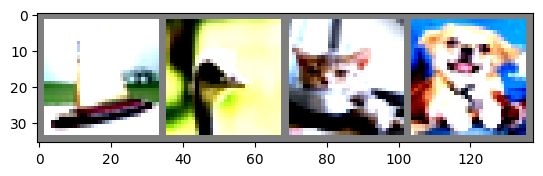

ship  bird  cat   dog  


In [45]:
# get some random training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
show_samples(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Build the Network - Sanity Check

In [46]:
model = Net(inch = [3,32,64,128], outch=[32,64,128,256], n_classes=10, dropoutval=[0.1]*4, ks=[3]*4, numlayers=[4,3,3,2], \
                 stride=[1]*4, dilation=[1,2,1,1], useBN = [True]*4, separable=[False, True, True, True]).to(device)
xx = torch.rand(1,3,32,32).to(device)
yy = model(xx)
yy.shape

torch.Size([1, 10])

In [47]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
      Convsubblock-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
           Dropout-9           [-1, 32, 32, 32]               0
     Convsubblock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
          Dropout-14           [-1, 32,

**Summary**
- We use depth separable convolution in Conv Block 2/3/4
- Num of layer in each block [4,3,2,2]
- Last layer of each block uses stride of 2 except the last Conv block (no MaxPool)
- With this we get out total params < 200K
- This fixes our basic skeleton
- We have programmable option to turn on BatchNorm and Dropout for regularization, faster convergence, supporting larger learning rates, handling internal covariate shift

# Experiment1: 
- (Basic Skeleton with params < 200k, No Maxpool, last layer stride=2, 2/3/4th layer has depth sep conv, num_layers=[4,3,3,2], dilation in second block with rate=2, No BN, No dropout, No data Aug)

In [57]:
model1 =  Net(inch=[3,32,64,128], outch=[32,64,128,256], n_classes=10, dropoutval=[0.001]*4, ks=[3]*4, numlayers=[4,3,3,2], \
                 stride=[1]*4, dilation=[1,2,1,1], useBN = [False]*4, separable=[False, True, True, True]).to(device)
summary(model1, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
      Convsubblock-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
           Dropout-7           [-1, 32, 32, 32]               0
      Convsubblock-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
          Dropout-11           [-1, 32, 32, 32]               0
     Convsubblock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
             ReLU-14           [-1, 32,

In [58]:
model1

Net(
  (convblk1): ConvBlock(
    (convblock): ModuleList(
      (0): Convsubblock(
        (conv_sblock): ModuleList(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU()
          (2): Dropout(p=0.001, inplace=False)
        )
      )
      (1-2): 2 x Convsubblock(
        (conv_sblock): ModuleList(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU()
          (2): Dropout(p=0.001, inplace=False)
        )
      )
      (3): Convsubblock(
        (conv_sblock): ModuleList(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): ReLU()
          (2): Dropout(p=0.001, inplace=False)
        )
      )
    )
  )
  (convblk2): ConvBlock(
    (convblock): ModuleList(
      (0): Convsubblock(
        (conv_sblock): ModuleList(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2

In [59]:
optimizer = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.Adam(model1.parameters(), lr=0.01)

train_stats = {}
test_stats = {}
EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model1, device, train_dl, optimizer, epoch, train_stats)
    #scheduler.step()
    test_epoch(model1, device, test_dl, test_stats)

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.18it/s]
Loss=2.3025848865509033 Batch_id=4 Accuracy=8.83:   3%|█                                | 3/98 [00:00<00:03, 24.87it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


Loss=2.302586078643799 Batch_id=97 Accuracy=10.01: 100%|███████████████████████████████| 98/98 [00:03<00:00, 24.96it/s]
Loss=2.3025848865509033 Batch_id=4 Accuracy=10.08:   3%|▉                               | 3/98 [00:00<00:03, 24.19it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:03<00:00, 24.54it/s]
Loss=2.3025848865509033 Batch_id=4 Accuracy=9.80:   3%|█                                | 3/98 [00:00<00:03, 24.00it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.98it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=11.13:   3%|▉                               | 3/98 [00:00<00:04, 22.22it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.93it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.91:   3%|█                                | 3/98 [00:00<00:04, 23.62it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 24.25it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.96:   3%|█                                | 3/98 [00:00<00:04, 21.56it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.87it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.01:   3%|▉                               | 3/98 [00:00<00:04, 23.41it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=2.302586078643799 Batch_id=97 Accuracy=9.99: 100%|████████████████████████████████| 98/98 [00:04<00:00, 24.30it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.67:   3%|█                                | 3/98 [00:00<00:04, 22.39it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.68it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.11:   3%|▉                               | 3/98 [00:00<00:03, 23.80it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=2.302586078643799 Batch_id=97 Accuracy=9.99: 100%|████████████████████████████████| 98/98 [00:04<00:00, 24.18it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.11:   3%|▉                               | 3/98 [00:00<00:03, 23.99it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.85it/s]
Loss=2.3025848865509033 Batch_id=4 Accuracy=8.91:   3%|█                                | 3/98 [00:00<00:04, 23.08it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.78it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.13:   3%|█                                | 3/98 [00:00<00:04, 22.73it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.22it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.77:   3%|█                                | 3/98 [00:00<00:04, 22.21it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.26it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.38:   3%|█                                | 3/98 [00:00<00:04, 21.74it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.05it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.60:   3%|▉                               | 3/98 [00:00<00:04, 23.08it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.47it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.30:   3%|▉                               | 3/98 [00:00<00:04, 21.90it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=2.302586078643799 Batch_id=97 Accuracy=9.99: 100%|████████████████████████████████| 98/98 [00:04<00:00, 22.78it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.67:   3%|█                                | 3/98 [00:00<00:04, 23.40it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.03it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=8.89:   3%|█                                | 3/98 [00:00<00:04, 21.35it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.79it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.47:   3%|█                                | 3/98 [00:00<00:04, 23.17it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 23.07it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.77:   3%|█                                | 3/98 [00:00<00:04, 22.93it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.73it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.72:   3%|█                                | 3/98 [00:00<00:04, 21.74it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 21


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.92it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.45:   3%|▉                               | 3/98 [00:00<00:04, 22.66it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 22


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.93it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.25:   3%|▉                               | 3/98 [00:00<00:04, 20.98it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 23


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.63it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.62:   3%|█                                | 3/98 [00:00<00:04, 20.83it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 24


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.66it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.25:   3%|▉                               | 3/98 [00:00<00:04, 21.58it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 25


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.48it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.06:   3%|▉                               | 3/98 [00:00<00:04, 21.58it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 26


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.41it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=9.42:   3%|█                                | 3/98 [00:00<00:04, 21.58it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 27


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.40it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.55:   3%|▉                               | 3/98 [00:00<00:04, 21.12it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 28


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.41it/s]
Loss=2.3025848865509033 Batch_id=3 Accuracy=10.35:   3%|▉                               | 3/98 [00:00<00:04, 22.69it/s]


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 29


Loss=2.302586078643799 Batch_id=97 Accuracy=10.00: 100%|███████████████████████████████| 98/98 [00:04<00:00, 22.50it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)



**Summary**
- We trained till 30 epochs and network is refusing to get trained, looks like optimizer is stuck in poor loss landscape
- Lets add Batch Norm which will smoothen the loss landscape and check if network starts training

# Experiment2: 
- **Experiment1** + BatchNorm

In [60]:
model2 =  Net(inch = [3,32,64,128], outch=[32,64,128,256], n_classes=10, dropoutval=[0.001]*4, ks=[3]*4, numlayers=[4,3,3,2], \
                 stride=[1]*4, dilation=[1,2,1,1], useBN = [True]*4, separable=[False, True, True, True]).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_stats = {}
test_stats = {}
EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model2, device, train_dl, optimizer, epoch, train_stats)
    #scheduler.step()
    test_epoch(model2, device, test_dl, test_stats)

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.654346227645874 Batch_id=97 Accuracy=25.97: 100%|███████████████████████████████| 98/98 [00:05<00:00, 18.98it/s]
Loss=1.61353600025177 Batch_id=2 Accuracy=35.94:   3%|█                                 | 3/98 [00:00<00:04, 20.27it/s]


Test set: Average loss: 1.7290, Accuracy: 3351/10000 (33.51%)

EPOCH: 1


Loss=1.471578598022461 Batch_id=97 Accuracy=41.59: 100%|███████████████████████████████| 98/98 [00:04<00:00, 20.51it/s]
Loss=1.2981419563293457 Batch_id=3 Accuracy=49.85:   3%|▉                               | 3/98 [00:00<00:04, 20.67it/s]


Test set: Average loss: 1.4833, Accuracy: 4428/10000 (44.28%)

EPOCH: 2


Loss=1.2353259325027466 Batch_id=97 Accuracy=52.47: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.68it/s]
Loss=1.1763614416122437 Batch_id=3 Accuracy=58.15:   3%|▉                               | 3/98 [00:00<00:04, 20.13it/s]


Test set: Average loss: 1.3580, Accuracy: 5071/10000 (50.71%)

EPOCH: 3


Loss=1.063629388809204 Batch_id=97 Accuracy=58.64: 100%|███████████████████████████████| 98/98 [00:04<00:00, 20.45it/s]
Loss=1.0838195085525513 Batch_id=3 Accuracy=61.91:   3%|▉                               | 3/98 [00:00<00:04, 20.41it/s]


Test set: Average loss: 1.1188, Accuracy: 5946/10000 (59.46%)

EPOCH: 4


Loss=0.9692797064781189 Batch_id=97 Accuracy=63.11: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.57it/s]
Loss=1.0114599466323853 Batch_id=3 Accuracy=65.77:   3%|▉                               | 3/98 [00:00<00:04, 20.27it/s]


Test set: Average loss: 1.1674, Accuracy: 5829/10000 (58.29%)

EPOCH: 5


Loss=0.9793198704719543 Batch_id=97 Accuracy=66.12: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.33it/s]
Loss=0.8567234873771667 Batch_id=2 Accuracy=68.75:   3%|▉                               | 3/98 [00:00<00:04, 20.51it/s]


Test set: Average loss: 1.1073, Accuracy: 6143/10000 (61.43%)

EPOCH: 6


Loss=0.7999995350837708 Batch_id=97 Accuracy=68.76: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.47it/s]
Loss=0.8196936845779419 Batch_id=3 Accuracy=71.24:   3%|▉                               | 3/98 [00:00<00:04, 19.87it/s]


Test set: Average loss: 0.9903, Accuracy: 6469/10000 (64.69%)

EPOCH: 7


Loss=0.8094768524169922 Batch_id=97 Accuracy=71.34: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.19it/s]
Loss=0.7172746658325195 Batch_id=3 Accuracy=73.49:   3%|▉                               | 3/98 [00:00<00:04, 20.52it/s]


Test set: Average loss: 0.9859, Accuracy: 6484/10000 (64.84%)

EPOCH: 8


Loss=0.6771570444107056 Batch_id=97 Accuracy=72.89: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.45it/s]
Loss=0.7580967545509338 Batch_id=3 Accuracy=75.15:   3%|▉                               | 3/98 [00:00<00:04, 20.27it/s]


Test set: Average loss: 0.9909, Accuracy: 6588/10000 (65.88%)

EPOCH: 9


Loss=0.6870585083961487 Batch_id=97 Accuracy=74.83: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.34it/s]
Loss=0.7119272351264954 Batch_id=3 Accuracy=76.12:   2%|▋                               | 2/98 [00:00<00:04, 19.80it/s]


Test set: Average loss: 0.9065, Accuracy: 6827/10000 (68.27%)

EPOCH: 10


Loss=0.593326210975647 Batch_id=97 Accuracy=76.62: 100%|███████████████████████████████| 98/98 [00:04<00:00, 20.29it/s]
Loss=0.6979981064796448 Batch_id=3 Accuracy=76.37:   2%|▋                               | 2/98 [00:00<00:04, 19.29it/s]


Test set: Average loss: 0.8913, Accuracy: 6911/10000 (69.11%)

EPOCH: 11


Loss=0.7297112941741943 Batch_id=97 Accuracy=77.94: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.80it/s]
Loss=0.6191319227218628 Batch_id=3 Accuracy=80.03:   2%|▋                               | 2/98 [00:00<00:04, 19.37it/s]


Test set: Average loss: 0.8912, Accuracy: 6941/10000 (69.41%)

EPOCH: 12


Loss=0.6270321607589722 Batch_id=97 Accuracy=78.79: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.72it/s]
Loss=0.48798468708992004 Batch_id=2 Accuracy=82.16:   2%|▋                              | 2/98 [00:00<00:04, 19.80it/s]


Test set: Average loss: 0.8954, Accuracy: 6956/10000 (69.56%)

EPOCH: 13


Loss=0.5596892237663269 Batch_id=97 Accuracy=80.27: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.93it/s]
Loss=0.5644101500511169 Batch_id=2 Accuracy=81.71:   2%|▋                               | 2/98 [00:00<00:04, 19.57it/s]


Test set: Average loss: 0.8968, Accuracy: 7008/10000 (70.08%)

EPOCH: 14


Loss=0.5595197677612305 Batch_id=97 Accuracy=81.16: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.93it/s]
Loss=0.5280693769454956 Batch_id=3 Accuracy=83.45:   2%|▋                               | 2/98 [00:00<00:04, 19.80it/s]


Test set: Average loss: 0.9301, Accuracy: 6946/10000 (69.46%)

EPOCH: 15


Loss=0.6088093519210815 Batch_id=97 Accuracy=82.53: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.91it/s]
Loss=0.4568622410297394 Batch_id=2 Accuracy=83.27:   2%|▋                               | 2/98 [00:00<00:05, 18.35it/s]


Test set: Average loss: 0.8793, Accuracy: 7121/10000 (71.21%)

EPOCH: 16


Loss=0.4654802083969116 Batch_id=97 Accuracy=83.40: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.91it/s]
Loss=0.45438018441200256 Batch_id=2 Accuracy=85.03:   2%|▋                              | 2/98 [00:00<00:04, 19.80it/s]


Test set: Average loss: 0.9055, Accuracy: 6995/10000 (69.95%)

EPOCH: 17


Loss=0.41597723960876465 Batch_id=97 Accuracy=84.18: 100%|█████████████████████████████| 98/98 [00:04<00:00, 19.86it/s]
Loss=0.35645821690559387 Batch_id=3 Accuracy=86.23:   2%|▋                              | 2/98 [00:00<00:04, 19.61it/s]


Test set: Average loss: 0.9060, Accuracy: 6986/10000 (69.86%)

EPOCH: 18


Loss=0.5289257764816284 Batch_id=97 Accuracy=85.05: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.63it/s]
Loss=0.37476760149002075 Batch_id=2 Accuracy=86.13:   2%|▋                              | 2/98 [00:00<00:05, 18.85it/s]


Test set: Average loss: 0.9707, Accuracy: 6970/10000 (69.70%)

EPOCH: 19


Loss=0.48892471194267273 Batch_id=97 Accuracy=85.49: 100%|█████████████████████████████| 98/98 [00:04<00:00, 19.69it/s]
Loss=0.3394453525543213 Batch_id=3 Accuracy=87.79:   2%|▋                               | 2/98 [00:00<00:04, 19.82it/s]


Test set: Average loss: 0.9783, Accuracy: 7055/10000 (70.55%)

EPOCH: 20


Loss=0.4308405816555023 Batch_id=97 Accuracy=86.71: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.67it/s]
Loss=0.37633419036865234 Batch_id=2 Accuracy=87.76:   2%|▋                              | 2/98 [00:00<00:04, 19.38it/s]


Test set: Average loss: 0.9277, Accuracy: 7108/10000 (71.08%)

EPOCH: 21


Loss=0.4006757140159607 Batch_id=97 Accuracy=87.22: 100%|██████████████████████████████| 98/98 [00:05<00:00, 19.55it/s]
Loss=0.2915288805961609 Batch_id=3 Accuracy=89.70:   2%|▋                               | 2/98 [00:00<00:04, 20.00it/s]


Test set: Average loss: 0.9505, Accuracy: 7113/10000 (71.13%)

EPOCH: 22


Loss=0.3674887716770172 Batch_id=97 Accuracy=87.99: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.69it/s]
Loss=0.2938041388988495 Batch_id=3 Accuracy=89.50:   2%|▋                               | 2/98 [00:00<00:05, 18.69it/s]


Test set: Average loss: 1.0311, Accuracy: 7021/10000 (70.21%)

EPOCH: 23


Loss=0.5251187086105347 Batch_id=97 Accuracy=88.01: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.72it/s]
Loss=0.2684164345264435 Batch_id=2 Accuracy=90.69:   2%|▋                               | 2/98 [00:00<00:04, 19.41it/s]


Test set: Average loss: 0.9833, Accuracy: 7079/10000 (70.79%)

EPOCH: 24


Loss=0.3132132589817047 Batch_id=97 Accuracy=88.73: 100%|██████████████████████████████| 98/98 [00:05<00:00, 19.50it/s]
Loss=0.2216763198375702 Batch_id=3 Accuracy=90.62:   2%|▋                               | 2/98 [00:00<00:04, 19.80it/s]


Test set: Average loss: 1.0210, Accuracy: 7036/10000 (70.36%)

EPOCH: 25


Loss=0.30300289392471313 Batch_id=97 Accuracy=89.61: 100%|█████████████████████████████| 98/98 [00:05<00:00, 19.48it/s]
Loss=0.17399537563323975 Batch_id=3 Accuracy=93.36:   3%|▉                              | 3/98 [00:00<00:04, 20.14it/s]


Test set: Average loss: 0.9855, Accuracy: 7169/10000 (71.69%)

EPOCH: 26


Loss=0.29757437109947205 Batch_id=97 Accuracy=90.47: 100%|█████████████████████████████| 98/98 [00:04<00:00, 19.63it/s]
Loss=0.25630223751068115 Batch_id=3 Accuracy=92.29:   2%|▋                              | 2/98 [00:00<00:04, 19.61it/s]


Test set: Average loss: 1.0817, Accuracy: 7154/10000 (71.54%)

EPOCH: 27


Loss=0.31932491064071655 Batch_id=97 Accuracy=90.19: 100%|█████████████████████████████| 98/98 [00:04<00:00, 19.74it/s]
Loss=0.23808905482292175 Batch_id=2 Accuracy=89.97:   3%|▉                              | 3/98 [00:00<00:04, 20.40it/s]


Test set: Average loss: 1.1097, Accuracy: 7012/10000 (70.12%)

EPOCH: 28


Loss=0.26493754982948303 Batch_id=97 Accuracy=90.83: 100%|█████████████████████████████| 98/98 [00:05<00:00, 19.39it/s]
Loss=0.20170584321022034 Batch_id=3 Accuracy=91.99:   3%|▉                              | 3/98 [00:00<00:04, 20.05it/s]


Test set: Average loss: 1.0588, Accuracy: 7062/10000 (70.62%)

EPOCH: 29


Loss=0.32546287775039673 Batch_id=97 Accuracy=91.10: 100%|█████████████████████████████| 98/98 [00:04<00:00, 19.70it/s]



Test set: Average loss: 1.1202, Accuracy: 6969/10000 (69.69%)



**Summary**
- BN helps in network getting trained
- But we see heavy overfitting
- Lets add some dropout and train again

# Experiment3: 
- **Experiment2** + BN + Dropout (=0.1)

In [62]:
model2 =  Net(inch = [3,32,64,128], outch=[32,64,128,256], n_classes=10, dropoutval=[0.1]*4, ks=[3]*4, numlayers=[4,3,3,2], \
                 stride=[1]*4, dilation=[1,2,1,1], useBN = [True]*4, separable=[False, True, True, True]).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_stats = {}
test_stats = {}
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model2, device, train_dl, optimizer, epoch, train_stats)
    #scheduler.step()
    test_epoch(model2, device, test_dl, test_stats)

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.9211113452911377 Batch_id=97 Accuracy=18.82: 100%|██████████████████████████████| 98/98 [00:05<00:00, 19.42it/s]
Loss=1.8250465393066406 Batch_id=3 Accuracy=27.29:   3%|▉                               | 3/98 [00:00<00:04, 20.65it/s]


Test set: Average loss: 2.1252, Accuracy: 1882/10000 (18.82%)

EPOCH: 1


Loss=1.7466403245925903 Batch_id=97 Accuracy=31.40: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.75it/s]
Loss=1.6546984910964966 Batch_id=3 Accuracy=35.45:   3%|▉                               | 3/98 [00:00<00:04, 20.39it/s]


Test set: Average loss: 1.7553, Accuracy: 3115/10000 (31.15%)

EPOCH: 2


Loss=1.5919790267944336 Batch_id=97 Accuracy=38.66: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.68it/s]
Loss=1.5960496664047241 Batch_id=2 Accuracy=41.80:   3%|▉                               | 3/98 [00:00<00:04, 20.35it/s]


Test set: Average loss: 1.6106, Accuracy: 4016/10000 (40.16%)

EPOCH: 3


Loss=1.3514779806137085 Batch_id=97 Accuracy=47.11: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.46it/s]
Loss=1.2598830461502075 Batch_id=3 Accuracy=51.95:   2%|▋                               | 2/98 [00:00<00:04, 19.82it/s]


Test set: Average loss: 1.4050, Accuracy: 4936/10000 (49.36%)

EPOCH: 4


Loss=1.2372404336929321 Batch_id=97 Accuracy=52.46: 100%|██████████████████████████████| 98/98 [00:04<00:00, 20.13it/s]
Loss=1.2420601844787598 Batch_id=3 Accuracy=53.12:   3%|▉                               | 3/98 [00:00<00:04, 20.07it/s]


Test set: Average loss: 1.3607, Accuracy: 5145/10000 (51.45%)

EPOCH: 5


Loss=1.1385966539382935 Batch_id=97 Accuracy=56.11: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.66it/s]
Loss=1.113437533378601 Batch_id=3 Accuracy=55.71:   2%|▋                                | 2/98 [00:00<00:04, 19.41it/s]


Test set: Average loss: 1.3052, Accuracy: 5401/10000 (54.01%)

EPOCH: 6


Loss=1.1433687210083008 Batch_id=97 Accuracy=59.18: 100%|██████████████████████████████| 98/98 [00:05<00:00, 19.57it/s]
Loss=1.068827748298645 Batch_id=2 Accuracy=59.83:   2%|▋                                | 2/98 [00:00<00:05, 18.69it/s]


Test set: Average loss: 1.1413, Accuracy: 5935/10000 (59.35%)

EPOCH: 7


Loss=0.9892387390136719 Batch_id=97 Accuracy=61.45: 100%|██████████████████████████████| 98/98 [00:04<00:00, 19.60it/s]
Loss=1.0297479629516602 Batch_id=3 Accuracy=62.84:   2%|▋                               | 2/98 [00:00<00:04, 19.80it/s]


Test set: Average loss: 1.0735, Accuracy: 6150/10000 (61.50%)

EPOCH: 8


Loss=1.1074553728103638 Batch_id=97 Accuracy=63.35: 100%|██████████████████████████████| 98/98 [00:05<00:00, 19.22it/s]
Loss=0.9508846402168274 Batch_id=2 Accuracy=65.62:   2%|▋                               | 2/98 [00:00<00:04, 19.24it/s]


Test set: Average loss: 1.0983, Accuracy: 6100/10000 (61.00%)

EPOCH: 9


Loss=1.0327539443969727 Batch_id=97 Accuracy=64.58: 100%|██████████████████████████████| 98/98 [00:05<00:00, 19.19it/s]
Loss=0.9573809504508972 Batch_id=2 Accuracy=65.56:   2%|▋                               | 2/98 [00:00<00:05, 18.34it/s]


Test set: Average loss: 0.9406, Accuracy: 6594/10000 (65.94%)

EPOCH: 10


Loss=1.0431283712387085 Batch_id=97 Accuracy=65.33: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.81it/s]
Loss=0.9747734069824219 Batch_id=2 Accuracy=66.28:   2%|▋                               | 2/98 [00:00<00:05, 17.69it/s]


Test set: Average loss: 0.9383, Accuracy: 6662/10000 (66.62%)

EPOCH: 11


Loss=1.0102097988128662 Batch_id=97 Accuracy=66.73: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.73it/s]
Loss=0.9439374208450317 Batch_id=2 Accuracy=66.41:   2%|▋                               | 2/98 [00:00<00:05, 17.39it/s]


Test set: Average loss: 0.9177, Accuracy: 6697/10000 (66.97%)

EPOCH: 12


Loss=0.8190501928329468 Batch_id=97 Accuracy=67.45: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.65it/s]
Loss=0.9440985321998596 Batch_id=2 Accuracy=67.25:   2%|▋                               | 2/98 [00:00<00:05, 17.55it/s]


Test set: Average loss: 0.9269, Accuracy: 6735/10000 (67.35%)

EPOCH: 13


Loss=0.7623705863952637 Batch_id=97 Accuracy=68.66: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.54it/s]
Loss=0.8170521855354309 Batch_id=2 Accuracy=71.42:   2%|▋                               | 2/98 [00:00<00:05, 18.17it/s]


Test set: Average loss: 0.9316, Accuracy: 6731/10000 (67.31%)

EPOCH: 14


Loss=0.7849419116973877 Batch_id=97 Accuracy=69.27: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.45it/s]
Loss=0.8894811868667603 Batch_id=3 Accuracy=70.21:   2%|▋                               | 2/98 [00:00<00:05, 18.32it/s]


Test set: Average loss: 0.8203, Accuracy: 7099/10000 (70.99%)

EPOCH: 15


Loss=0.9226433038711548 Batch_id=97 Accuracy=69.88: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.13it/s]
Loss=0.844153881072998 Batch_id=2 Accuracy=67.97:   2%|▋                                | 2/98 [00:00<00:05, 18.18it/s]


Test set: Average loss: 0.8363, Accuracy: 6999/10000 (69.99%)

EPOCH: 16


Loss=0.8146677613258362 Batch_id=97 Accuracy=71.17: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.95it/s]
Loss=0.8083298206329346 Batch_id=2 Accuracy=71.94:   2%|▋                               | 2/98 [00:00<00:05, 17.85it/s]


Test set: Average loss: 0.8705, Accuracy: 6937/10000 (69.37%)

EPOCH: 17


Loss=0.7652595043182373 Batch_id=97 Accuracy=71.69: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.14it/s]
Loss=0.7905805706977844 Batch_id=2 Accuracy=71.61:   2%|▋                               | 2/98 [00:00<00:05, 17.82it/s]


Test set: Average loss: 0.8104, Accuracy: 7162/10000 (71.62%)

EPOCH: 18


Loss=0.7362297773361206 Batch_id=97 Accuracy=72.28: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.09it/s]
Loss=0.7226902842521667 Batch_id=2 Accuracy=74.74:   2%|▋                               | 2/98 [00:00<00:05, 18.65it/s]


Test set: Average loss: 0.8235, Accuracy: 7114/10000 (71.14%)

EPOCH: 19


Loss=0.7150582671165466 Batch_id=97 Accuracy=72.98: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.99it/s]
Loss=0.7267758846282959 Batch_id=2 Accuracy=75.46:   2%|▋                               | 2/98 [00:00<00:05, 17.77it/s]


Test set: Average loss: 0.7610, Accuracy: 7297/10000 (72.97%)

EPOCH: 20


Loss=0.7875934839248657 Batch_id=97 Accuracy=73.08: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.76it/s]
Loss=0.7293842434883118 Batch_id=1 Accuracy=73.83:   2%|▋                               | 2/98 [00:00<00:05, 17.77it/s]


Test set: Average loss: 0.7595, Accuracy: 7348/10000 (73.48%)

EPOCH: 21


Loss=0.6932471394538879 Batch_id=97 Accuracy=73.94: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.90it/s]
Loss=0.7753618359565735 Batch_id=2 Accuracy=72.33:   2%|▋                               | 2/98 [00:00<00:05, 17.54it/s]


Test set: Average loss: 0.8174, Accuracy: 7124/10000 (71.24%)

EPOCH: 22


Loss=0.73320072889328 Batch_id=97 Accuracy=74.32: 100%|████████████████████████████████| 98/98 [00:05<00:00, 17.48it/s]
Loss=0.70395827293396 Batch_id=2 Accuracy=74.74:   2%|▋                                 | 2/98 [00:00<00:05, 17.18it/s]


Test set: Average loss: 0.8175, Accuracy: 7170/10000 (71.70%)

EPOCH: 23


Loss=0.7119450569152832 Batch_id=97 Accuracy=74.75: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.45it/s]
Loss=0.718507707118988 Batch_id=2 Accuracy=75.26:   2%|▋                                | 2/98 [00:00<00:05, 17.69it/s]


Test set: Average loss: 0.7690, Accuracy: 7319/10000 (73.19%)

EPOCH: 24


Loss=0.7158117890357971 Batch_id=97 Accuracy=75.21: 100%|██████████████████████████████| 98/98 [00:05<00:00, 18.01it/s]
Loss=0.7079740166664124 Batch_id=2 Accuracy=74.02:   2%|▋                               | 2/98 [00:00<00:05, 17.54it/s]


Test set: Average loss: 0.7297, Accuracy: 7469/10000 (74.69%)

EPOCH: 25


Loss=0.7010464072227478 Batch_id=97 Accuracy=75.89: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.27it/s]
Loss=0.6696273684501648 Batch_id=2 Accuracy=75.85:   2%|▋                               | 2/98 [00:00<00:05, 18.30it/s]


Test set: Average loss: 0.7181, Accuracy: 7487/10000 (74.87%)

EPOCH: 26


Loss=0.6975200176239014 Batch_id=97 Accuracy=76.08: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.04it/s]
Loss=0.6979134678840637 Batch_id=2 Accuracy=75.85:   2%|▋                               | 2/98 [00:00<00:05, 17.09it/s]


Test set: Average loss: 0.7292, Accuracy: 7524/10000 (75.24%)

EPOCH: 27


Loss=0.7020783424377441 Batch_id=97 Accuracy=76.20: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.35it/s]
Loss=0.6395598649978638 Batch_id=2 Accuracy=79.30:   2%|▋                               | 2/98 [00:00<00:05, 18.12it/s]


Test set: Average loss: 0.7823, Accuracy: 7354/10000 (73.54%)

EPOCH: 28


Loss=0.6603896617889404 Batch_id=97 Accuracy=76.73: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.46it/s]
Loss=0.6737097501754761 Batch_id=2 Accuracy=76.76:   2%|▋                               | 2/98 [00:00<00:05, 17.58it/s]


Test set: Average loss: 0.6640, Accuracy: 7724/10000 (77.24%)

EPOCH: 29


Loss=0.5988417267799377 Batch_id=97 Accuracy=77.39: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.65it/s]
Loss=0.5883309245109558 Batch_id=2 Accuracy=76.63:   2%|▋                               | 2/98 [00:00<00:05, 17.74it/s]


Test set: Average loss: 0.6886, Accuracy: 7603/10000 (76.03%)

EPOCH: 30


Loss=0.7021826505661011 Batch_id=97 Accuracy=77.49: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.42it/s]
Loss=0.635672390460968 Batch_id=2 Accuracy=78.19:   2%|▋                                | 2/98 [00:00<00:05, 16.10it/s]


Test set: Average loss: 0.6902, Accuracy: 7616/10000 (76.16%)

EPOCH: 31


Loss=0.7153044939041138 Batch_id=97 Accuracy=77.84: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.41it/s]
Loss=0.5489524602890015 Batch_id=2 Accuracy=80.21:   2%|▋                               | 2/98 [00:00<00:05, 17.12it/s]


Test set: Average loss: 0.6710, Accuracy: 7686/10000 (76.86%)

EPOCH: 32


Loss=0.6935688853263855 Batch_id=97 Accuracy=78.15: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.53it/s]
Loss=0.6413669586181641 Batch_id=2 Accuracy=77.60:   2%|▋                               | 2/98 [00:00<00:05, 17.22it/s]


Test set: Average loss: 0.6504, Accuracy: 7761/10000 (77.61%)

EPOCH: 33


Loss=0.6320514678955078 Batch_id=97 Accuracy=78.52: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.62it/s]
Loss=0.5757094025611877 Batch_id=2 Accuracy=80.27:   2%|▋                               | 2/98 [00:00<00:05, 17.71it/s]


Test set: Average loss: 0.6484, Accuracy: 7753/10000 (77.53%)

EPOCH: 34


Loss=0.6749892234802246 Batch_id=97 Accuracy=78.78: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.36it/s]
Loss=0.6292678117752075 Batch_id=2 Accuracy=79.17:   2%|▋                               | 2/98 [00:00<00:05, 17.35it/s]


Test set: Average loss: 0.6880, Accuracy: 7634/10000 (76.34%)

EPOCH: 35


Loss=0.6616259813308716 Batch_id=97 Accuracy=78.84: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.23it/s]
Loss=0.6207131147384644 Batch_id=2 Accuracy=79.30:   2%|▋                               | 2/98 [00:00<00:05, 16.67it/s]


Test set: Average loss: 0.6347, Accuracy: 7826/10000 (78.26%)

EPOCH: 36


Loss=0.5149275660514832 Batch_id=97 Accuracy=79.40: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.42it/s]
Loss=0.6154590845108032 Batch_id=2 Accuracy=80.01:   2%|▋                               | 2/98 [00:00<00:05, 17.54it/s]


Test set: Average loss: 0.6437, Accuracy: 7794/10000 (77.94%)

EPOCH: 37


Loss=0.6208218932151794 Batch_id=97 Accuracy=79.53: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.18it/s]
Loss=0.5344030261039734 Batch_id=2 Accuracy=79.23:   2%|▋                               | 2/98 [00:00<00:06, 15.87it/s]


Test set: Average loss: 0.6220, Accuracy: 7855/10000 (78.55%)

EPOCH: 38


Loss=0.6519905924797058 Batch_id=97 Accuracy=79.60: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.57it/s]
Loss=0.642644464969635 Batch_id=2 Accuracy=78.45:   2%|▋                                | 2/98 [00:00<00:05, 16.53it/s]


Test set: Average loss: 0.6665, Accuracy: 7743/10000 (77.43%)

EPOCH: 39


Loss=0.49537885189056396 Batch_id=97 Accuracy=79.76: 100%|█████████████████████████████| 98/98 [00:05<00:00, 17.13it/s]
Loss=0.5800017714500427 Batch_id=2 Accuracy=80.53:   2%|▋                               | 2/98 [00:00<00:05, 16.14it/s]


Test set: Average loss: 0.6347, Accuracy: 7857/10000 (78.57%)

EPOCH: 40


Loss=0.5540038347244263 Batch_id=97 Accuracy=79.98: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.83it/s]
Loss=0.5921012163162231 Batch_id=2 Accuracy=78.91:   2%|▋                               | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.6327, Accuracy: 7862/10000 (78.62%)

EPOCH: 41


Loss=0.5685282349586487 Batch_id=97 Accuracy=80.22: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.95it/s]
Loss=0.5288987159729004 Batch_id=2 Accuracy=81.64:   2%|▋                               | 2/98 [00:00<00:06, 15.11it/s]


Test set: Average loss: 0.6545, Accuracy: 7777/10000 (77.77%)

EPOCH: 42


Loss=0.6399133801460266 Batch_id=97 Accuracy=80.67: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.69it/s]
Loss=0.5356599688529968 Batch_id=2 Accuracy=80.79:   2%|▋                               | 2/98 [00:00<00:05, 16.53it/s]


Test set: Average loss: 0.6066, Accuracy: 7901/10000 (79.01%)

EPOCH: 43


Loss=0.5142425298690796 Batch_id=97 Accuracy=80.83: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.77it/s]
Loss=0.572409451007843 Batch_id=2 Accuracy=80.66:   2%|▋                                | 2/98 [00:00<00:05, 16.53it/s]


Test set: Average loss: 0.6413, Accuracy: 7819/10000 (78.19%)

EPOCH: 44


Loss=0.5520747303962708 Batch_id=97 Accuracy=81.04: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.40it/s]
Loss=0.5651562213897705 Batch_id=2 Accuracy=79.95:   2%|▋                               | 2/98 [00:00<00:05, 16.26it/s]


Test set: Average loss: 0.6091, Accuracy: 7930/10000 (79.30%)

EPOCH: 45


Loss=0.5769500136375427 Batch_id=97 Accuracy=81.13: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.54it/s]
Loss=0.5284090638160706 Batch_id=2 Accuracy=81.38:   2%|▋                               | 2/98 [00:00<00:05, 16.25it/s]


Test set: Average loss: 0.6251, Accuracy: 7920/10000 (79.20%)

EPOCH: 46


Loss=0.5516570210456848 Batch_id=97 Accuracy=81.27: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.90it/s]
Loss=0.5367887020111084 Batch_id=2 Accuracy=81.32:   2%|▋                               | 2/98 [00:00<00:05, 16.81it/s]


Test set: Average loss: 0.6035, Accuracy: 7954/10000 (79.54%)

EPOCH: 47


Loss=0.5424290299415588 Batch_id=97 Accuracy=81.27: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.95it/s]
Loss=0.48977991938591003 Batch_id=2 Accuracy=83.66:   2%|▋                              | 2/98 [00:00<00:05, 16.38it/s]


Test set: Average loss: 0.6128, Accuracy: 7902/10000 (79.02%)

EPOCH: 48


Loss=0.5427695512771606 Batch_id=97 Accuracy=81.48: 100%|██████████████████████████████| 98/98 [00:06<00:00, 16.10it/s]
Loss=0.45030486583709717 Batch_id=2 Accuracy=83.53:   2%|▋                              | 2/98 [00:00<00:05, 17.21it/s]


Test set: Average loss: 0.6051, Accuracy: 7936/10000 (79.36%)

EPOCH: 49


Loss=0.568141520023346 Batch_id=97 Accuracy=81.55: 100%|███████████████████████████████| 98/98 [00:05<00:00, 16.43it/s]
Loss=0.4915107488632202 Batch_id=1 Accuracy=81.64:   2%|▋                               | 2/98 [00:00<00:05, 16.26it/s]


Test set: Average loss: 0.5885, Accuracy: 8023/10000 (80.23%)

EPOCH: 50


Loss=0.5384936332702637 Batch_id=97 Accuracy=81.76: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.85it/s]
Loss=0.5222927331924438 Batch_id=2 Accuracy=81.58:   2%|▋                               | 2/98 [00:00<00:06, 15.15it/s]


Test set: Average loss: 0.6448, Accuracy: 7777/10000 (77.77%)

EPOCH: 51


Loss=0.5568442940711975 Batch_id=97 Accuracy=81.98: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.54it/s]
Loss=0.5173266530036926 Batch_id=2 Accuracy=82.23:   2%|▋                               | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.5693, Accuracy: 8040/10000 (80.40%)

EPOCH: 52


Loss=0.5112501382827759 Batch_id=97 Accuracy=82.09: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.43it/s]
Loss=0.5125484466552734 Batch_id=2 Accuracy=81.84:   2%|▋                               | 2/98 [00:00<00:06, 15.49it/s]


Test set: Average loss: 0.5764, Accuracy: 8068/10000 (80.68%)

EPOCH: 53


Loss=0.4211456775665283 Batch_id=97 Accuracy=82.32: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.39it/s]
Loss=0.42210811376571655 Batch_id=2 Accuracy=83.40:   2%|▋                              | 2/98 [00:00<00:05, 16.77it/s]


Test set: Average loss: 0.5656, Accuracy: 8055/10000 (80.55%)

EPOCH: 54


Loss=0.4881528615951538 Batch_id=97 Accuracy=82.61: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.59it/s]
Loss=0.5090101361274719 Batch_id=2 Accuracy=83.33:   2%|▋                               | 2/98 [00:00<00:05, 16.23it/s]


Test set: Average loss: 0.5600, Accuracy: 8085/10000 (80.85%)

EPOCH: 55


Loss=0.5363108515739441 Batch_id=97 Accuracy=82.56: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.41it/s]
Loss=0.43986719846725464 Batch_id=2 Accuracy=83.66:   2%|▋                              | 2/98 [00:00<00:05, 16.53it/s]


Test set: Average loss: 0.5689, Accuracy: 8071/10000 (80.71%)

EPOCH: 56


Loss=0.5389785170555115 Batch_id=97 Accuracy=82.90: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.54it/s]
Loss=0.494017630815506 Batch_id=2 Accuracy=81.90:   2%|▋                                | 2/98 [00:00<00:06, 15.26it/s]


Test set: Average loss: 0.5716, Accuracy: 8078/10000 (80.78%)

EPOCH: 57


Loss=0.46020203828811646 Batch_id=97 Accuracy=82.58: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.80it/s]
Loss=0.4710724949836731 Batch_id=2 Accuracy=83.59:   2%|▋                               | 2/98 [00:00<00:06, 15.21it/s]


Test set: Average loss: 0.5772, Accuracy: 8062/10000 (80.62%)

EPOCH: 58


Loss=0.45433416962623596 Batch_id=97 Accuracy=83.09: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.90it/s]
Loss=0.48825734853744507 Batch_id=2 Accuracy=83.07:   2%|▋                              | 2/98 [00:00<00:06, 14.29it/s]


Test set: Average loss: 0.5670, Accuracy: 8080/10000 (80.80%)

EPOCH: 59


Loss=0.49093082547187805 Batch_id=97 Accuracy=83.31: 100%|█████████████████████████████| 98/98 [00:07<00:00, 12.42it/s]
Loss=0.4884415864944458 Batch_id=2 Accuracy=82.49:   2%|▋                               | 2/98 [00:00<00:06, 15.63it/s]


Test set: Average loss: 0.5759, Accuracy: 8073/10000 (80.73%)

EPOCH: 60


Loss=0.5088976621627808 Batch_id=97 Accuracy=83.46: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.40it/s]
Loss=0.5363236665725708 Batch_id=2 Accuracy=82.10:   2%|▋                               | 2/98 [00:00<00:05, 16.78it/s]


Test set: Average loss: 0.5654, Accuracy: 8111/10000 (81.11%)

EPOCH: 61


Loss=0.5306124091148376 Batch_id=97 Accuracy=83.33: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.51it/s]
Loss=0.46755272150039673 Batch_id=2 Accuracy=84.05:   2%|▋                              | 2/98 [00:00<00:05, 16.44it/s]


Test set: Average loss: 0.5510, Accuracy: 8140/10000 (81.40%)

EPOCH: 62


Loss=0.5157058835029602 Batch_id=97 Accuracy=83.28: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.86it/s]
Loss=0.4547596573829651 Batch_id=2 Accuracy=85.03:   2%|▋                               | 2/98 [00:00<00:06, 14.71it/s]


Test set: Average loss: 0.5585, Accuracy: 8093/10000 (80.93%)

EPOCH: 63


Loss=0.5185081362724304 Batch_id=97 Accuracy=83.44: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.54it/s]
Loss=0.44607239961624146 Batch_id=2 Accuracy=84.96:   2%|▋                              | 2/98 [00:00<00:05, 16.44it/s]


Test set: Average loss: 0.5617, Accuracy: 8113/10000 (81.13%)

EPOCH: 64


Loss=0.4978812634944916 Batch_id=97 Accuracy=83.67: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.88it/s]
Loss=0.44533655047416687 Batch_id=2 Accuracy=84.83:   2%|▋                              | 2/98 [00:00<00:05, 16.26it/s]


Test set: Average loss: 0.5673, Accuracy: 8076/10000 (80.76%)

EPOCH: 65


Loss=0.4483708441257477 Batch_id=97 Accuracy=83.77: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.87it/s]
Loss=0.4008082449436188 Batch_id=2 Accuracy=83.92:   2%|▋                               | 2/98 [00:00<00:06, 15.98it/s]


Test set: Average loss: 0.5566, Accuracy: 8120/10000 (81.20%)

EPOCH: 66


Loss=0.39961937069892883 Batch_id=97 Accuracy=83.88: 100%|█████████████████████████████| 98/98 [00:06<00:00, 16.00it/s]
Loss=0.5142754316329956 Batch_id=2 Accuracy=83.72:   2%|▋                               | 2/98 [00:00<00:06, 15.87it/s]


Test set: Average loss: 0.5524, Accuracy: 8131/10000 (81.31%)

EPOCH: 67


Loss=0.4442950189113617 Batch_id=97 Accuracy=84.13: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.34it/s]
Loss=0.46532440185546875 Batch_id=2 Accuracy=84.31:   2%|▋                              | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.5475, Accuracy: 8195/10000 (81.95%)

EPOCH: 68


Loss=0.5016781687736511 Batch_id=97 Accuracy=84.09: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.62it/s]
Loss=0.39269062876701355 Batch_id=2 Accuracy=84.57:   2%|▋                              | 2/98 [00:00<00:06, 15.38it/s]


Test set: Average loss: 0.5568, Accuracy: 8138/10000 (81.38%)

EPOCH: 69


Loss=0.4792236089706421 Batch_id=97 Accuracy=84.31: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.44it/s]
Loss=0.44476085901260376 Batch_id=2 Accuracy=85.87:   2%|▋                              | 2/98 [00:00<00:06, 15.04it/s]


Test set: Average loss: 0.5783, Accuracy: 8109/10000 (81.09%)

EPOCH: 70


Loss=0.4580017626285553 Batch_id=97 Accuracy=84.44: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.97it/s]
Loss=0.37994444370269775 Batch_id=2 Accuracy=85.09:   2%|▋                              | 2/98 [00:00<00:06, 15.15it/s]


Test set: Average loss: 0.5626, Accuracy: 8124/10000 (81.24%)

EPOCH: 71


Loss=0.431488037109375 Batch_id=97 Accuracy=84.31: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.50it/s]
Loss=0.3808221220970154 Batch_id=2 Accuracy=85.29:   2%|▋                               | 2/98 [00:00<00:05, 16.49it/s]


Test set: Average loss: 0.5577, Accuracy: 8150/10000 (81.50%)

EPOCH: 72


Loss=0.43329691886901855 Batch_id=97 Accuracy=84.45: 100%|█████████████████████████████| 98/98 [00:05<00:00, 16.40it/s]
Loss=0.4531380236148834 Batch_id=1 Accuracy=84.18:   2%|▋                               | 2/98 [00:00<00:06, 15.45it/s]


Test set: Average loss: 0.6029, Accuracy: 8026/10000 (80.26%)

EPOCH: 73


Loss=0.448853999376297 Batch_id=97 Accuracy=84.61: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.98it/s]
Loss=0.3766723871231079 Batch_id=2 Accuracy=84.96:   2%|▋                               | 2/98 [00:00<00:05, 16.74it/s]


Test set: Average loss: 0.5322, Accuracy: 8215/10000 (82.15%)

EPOCH: 74


Loss=0.4121919274330139 Batch_id=97 Accuracy=84.74: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.00it/s]
Loss=0.4069778323173523 Batch_id=2 Accuracy=85.29:   2%|▋                               | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.5512, Accuracy: 8180/10000 (81.80%)

EPOCH: 75


Loss=0.40593868494033813 Batch_id=97 Accuracy=84.65: 100%|█████████████████████████████| 98/98 [00:05<00:00, 16.60it/s]
Loss=0.4008602499961853 Batch_id=1 Accuracy=85.06:   2%|▋                               | 2/98 [00:00<00:06, 14.81it/s]


Test set: Average loss: 0.5306, Accuracy: 8218/10000 (82.18%)

EPOCH: 76


Loss=0.38446182012557983 Batch_id=97 Accuracy=84.78: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.53it/s]
Loss=0.4199599027633667 Batch_id=1 Accuracy=84.38:   2%|▋                               | 2/98 [00:00<00:06, 15.28it/s]


Test set: Average loss: 0.5578, Accuracy: 8145/10000 (81.45%)

EPOCH: 77


Loss=0.4311603009700775 Batch_id=97 Accuracy=85.01: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.98it/s]
Loss=0.3938327133655548 Batch_id=2 Accuracy=85.29:   2%|▋                               | 2/98 [00:00<00:05, 16.82it/s]


Test set: Average loss: 0.5763, Accuracy: 8134/10000 (81.34%)

EPOCH: 78


Loss=0.41662487387657166 Batch_id=97 Accuracy=85.03: 100%|█████████████████████████████| 98/98 [00:05<00:00, 16.92it/s]
Loss=0.36964911222457886 Batch_id=2 Accuracy=86.52:   2%|▋                              | 2/98 [00:00<00:06, 15.01it/s]


Test set: Average loss: 0.5532, Accuracy: 8150/10000 (81.50%)

EPOCH: 79


Loss=0.38661515712738037 Batch_id=97 Accuracy=85.29: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.28it/s]
Loss=0.3575175702571869 Batch_id=2 Accuracy=86.07:   2%|▋                               | 2/98 [00:00<00:06, 15.87it/s]


Test set: Average loss: 0.5275, Accuracy: 8258/10000 (82.58%)

EPOCH: 80


Loss=0.42951247096061707 Batch_id=97 Accuracy=84.95: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.61it/s]
Loss=0.3940957486629486 Batch_id=2 Accuracy=85.87:   2%|▋                               | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.5340, Accuracy: 8221/10000 (82.21%)

EPOCH: 81


Loss=0.38681620359420776 Batch_id=97 Accuracy=85.46: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.27it/s]
Loss=0.37523016333580017 Batch_id=2 Accuracy=85.03:   2%|▋                              | 2/98 [00:00<00:06, 15.45it/s]


Test set: Average loss: 0.5577, Accuracy: 8195/10000 (81.95%)

EPOCH: 82


Loss=0.5063222050666809 Batch_id=97 Accuracy=85.28: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.26it/s]
Loss=0.3949264585971832 Batch_id=1 Accuracy=86.33:   2%|▋                               | 2/98 [00:00<00:07, 13.15it/s]


Test set: Average loss: 0.5450, Accuracy: 8222/10000 (82.22%)

EPOCH: 83


Loss=0.3960181176662445 Batch_id=97 Accuracy=85.34: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.40it/s]
Loss=0.3753863573074341 Batch_id=1 Accuracy=86.82:   2%|▋                               | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.5181, Accuracy: 8315/10000 (83.15%)

EPOCH: 84


Loss=0.4625791907310486 Batch_id=97 Accuracy=85.42: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.18it/s]
Loss=0.3802095353603363 Batch_id=1 Accuracy=86.82:   2%|▋                               | 2/98 [00:00<00:07, 12.94it/s]


Test set: Average loss: 0.5157, Accuracy: 8313/10000 (83.13%)

EPOCH: 85


Loss=0.42484354972839355 Batch_id=97 Accuracy=85.36: 100%|█████████████████████████████| 98/98 [00:08<00:00, 12.07it/s]
Loss=0.4341138005256653 Batch_id=2 Accuracy=84.05:   2%|▋                               | 2/98 [00:00<00:05, 16.08it/s]


Test set: Average loss: 0.5655, Accuracy: 8168/10000 (81.68%)

EPOCH: 86


Loss=0.42573946714401245 Batch_id=97 Accuracy=85.51: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.96it/s]
Loss=0.4161311089992523 Batch_id=2 Accuracy=83.98:   2%|▋                               | 2/98 [00:00<00:06, 15.62it/s]


Test set: Average loss: 0.5356, Accuracy: 8292/10000 (82.92%)

EPOCH: 87


Loss=0.4413122534751892 Batch_id=97 Accuracy=85.51: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.86it/s]
Loss=0.3461287021636963 Batch_id=2 Accuracy=86.00:   2%|▋                               | 2/98 [00:00<00:05, 16.00it/s]


Test set: Average loss: 0.5425, Accuracy: 8230/10000 (82.30%)

EPOCH: 88


Loss=0.38495296239852905 Batch_id=97 Accuracy=85.56: 100%|█████████████████████████████| 98/98 [00:07<00:00, 12.64it/s]
Loss=0.39587074518203735 Batch_id=2 Accuracy=85.87:   2%|▋                              | 2/98 [00:00<00:06, 15.03it/s]


Test set: Average loss: 0.5464, Accuracy: 8229/10000 (82.29%)

EPOCH: 89


Loss=0.4056570529937744 Batch_id=97 Accuracy=85.89: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.06it/s]
Loss=0.3729366958141327 Batch_id=1 Accuracy=86.04:   2%|▋                               | 2/98 [00:00<00:06, 14.71it/s]


Test set: Average loss: 0.5406, Accuracy: 8250/10000 (82.50%)

EPOCH: 90


Loss=0.36243993043899536 Batch_id=97 Accuracy=85.70: 100%|█████████████████████████████| 98/98 [00:06<00:00, 16.04it/s]
Loss=0.4855439066886902 Batch_id=2 Accuracy=85.09:   2%|▋                               | 2/98 [00:00<00:06, 15.97it/s]


Test set: Average loss: 0.5372, Accuracy: 8245/10000 (82.45%)

EPOCH: 91


Loss=0.3904706537723541 Batch_id=97 Accuracy=86.00: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.05it/s]
Loss=0.38399434089660645 Batch_id=1 Accuracy=86.33:   2%|▋                              | 2/98 [00:00<00:07, 13.25it/s]


Test set: Average loss: 0.5349, Accuracy: 8250/10000 (82.50%)

EPOCH: 92


Loss=0.4154611825942993 Batch_id=97 Accuracy=86.14: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.88it/s]
Loss=0.36575958132743835 Batch_id=2 Accuracy=86.20:   2%|▋                              | 2/98 [00:00<00:05, 16.36it/s]


Test set: Average loss: 0.5346, Accuracy: 8277/10000 (82.77%)

EPOCH: 93


Loss=0.40506812930107117 Batch_id=97 Accuracy=86.11: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.26it/s]
Loss=0.4203544855117798 Batch_id=2 Accuracy=87.11:   2%|▋                               | 2/98 [00:00<00:05, 16.67it/s]


Test set: Average loss: 0.5349, Accuracy: 8253/10000 (82.53%)

EPOCH: 94


Loss=0.3862685561180115 Batch_id=97 Accuracy=86.10: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.74it/s]
Loss=0.4082828164100647 Batch_id=1 Accuracy=86.52:   2%|▋                               | 2/98 [00:00<00:07, 12.82it/s]


Test set: Average loss: 0.5396, Accuracy: 8248/10000 (82.48%)

EPOCH: 95


Loss=0.3685072362422943 Batch_id=97 Accuracy=86.17: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.51it/s]
Loss=0.3962908387184143 Batch_id=2 Accuracy=87.17:   2%|▋                               | 2/98 [00:00<00:06, 14.92it/s]


Test set: Average loss: 0.5342, Accuracy: 8205/10000 (82.05%)

EPOCH: 96


Loss=0.39496463537216187 Batch_id=97 Accuracy=86.29: 100%|█████████████████████████████| 98/98 [00:06<00:00, 15.51it/s]
Loss=0.3929089903831482 Batch_id=2 Accuracy=87.17:   2%|▋                               | 2/98 [00:00<00:05, 16.14it/s]


Test set: Average loss: 0.5282, Accuracy: 8290/10000 (82.90%)

EPOCH: 97


Loss=0.3666432797908783 Batch_id=97 Accuracy=86.29: 100%|██████████████████████████████| 98/98 [00:06<00:00, 16.24it/s]
Loss=0.42505159974098206 Batch_id=2 Accuracy=86.20:   2%|▋                              | 2/98 [00:00<00:06, 15.36it/s]


Test set: Average loss: 0.5307, Accuracy: 8293/10000 (82.93%)

EPOCH: 98


Loss=0.4328203797340393 Batch_id=97 Accuracy=86.39: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.63it/s]
Loss=0.35617461800575256 Batch_id=2 Accuracy=86.98:   2%|▋                              | 2/98 [00:00<00:06, 15.27it/s]


Test set: Average loss: 0.5458, Accuracy: 8258/10000 (82.58%)

EPOCH: 99


Loss=0.354166716337204 Batch_id=97 Accuracy=86.46: 100%|███████████████████████████████| 98/98 [00:06<00:00, 14.64it/s]



Test set: Average loss: 0.5481, Accuracy: 8253/10000 (82.53%)



**Summary**
- We have test acc > 82% but we see some overfitting beyond 70-100 epochs
- Lets add some data augmentation to improve test acc with low overfitting

# Experiment4: 
- Exp3 + Data augmentation

In [63]:
train_tfms = get_transforms(basic=False)
test_tfms = get_transforms(basic=True)

train_ds = CIFAR10_dataset(data=train_data.data, targets=train_data.targets, transforms=train_tfms)
test_ds = CIFAR10_dataset(data=test_data.data, targets=test_data.targets, transforms=test_tfms)

train_dl = get_dataloader(train_ds, bs_cuda=512, bs_cpu=64, device=device)
test_dl = get_dataloader(test_ds, bs_cuda=512, bs_cpu=64, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


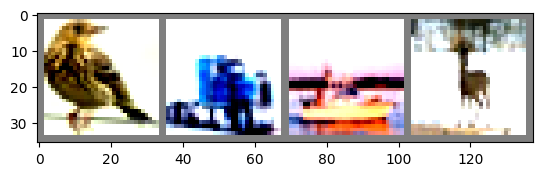

bird  truck ship  deer 


In [64]:
# visualize samples from training set with tfms
dataiter = iter(train_dl)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
show_samples(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [65]:
model4 =  Net(inch = [3,32,64,128], outch=[32,64,128,256], n_classes=10, dropoutval=[0.1]*4, ks=[3]*4, numlayers=[4,3,3,2], \
                 stride=[1]*4, dilation=[1,2,1,1], useBN = [True]*4, separable=[False, True, True, True]).to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_stats = {}
test_stats = {}
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model4, device, train_dl, optimizer, epoch, train_stats)
    #scheduler.step()
    test_epoch(model4, device, test_dl, test_stats)

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.9035515785217285 Batch_id=97 Accuracy=19.52: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.54it/s]
Loss=1.9443743228912354 Batch_id=2 Accuracy=25.07:   2%|▋                               | 2/98 [00:00<00:05, 17.09it/s]


Test set: Average loss: 1.8697, Accuracy: 2691/10000 (26.91%)

EPOCH: 1


Loss=1.8280999660491943 Batch_id=97 Accuracy=29.56: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.53it/s]
Loss=1.7352018356323242 Batch_id=2 Accuracy=33.92:   2%|▋                               | 2/98 [00:00<00:05, 16.81it/s]


Test set: Average loss: 1.8584, Accuracy: 2739/10000 (27.39%)

EPOCH: 2


Loss=1.7367907762527466 Batch_id=97 Accuracy=34.72: 100%|██████████████████████████████| 98/98 [00:05<00:00, 17.26it/s]
Loss=1.6756525039672852 Batch_id=2 Accuracy=37.24:   2%|▋                               | 2/98 [00:00<00:05, 16.95it/s]


Test set: Average loss: 1.6041, Accuracy: 3918/10000 (39.18%)

EPOCH: 3


Loss=1.550229787826538 Batch_id=97 Accuracy=39.34: 100%|███████████████████████████████| 98/98 [00:05<00:00, 17.18it/s]
Loss=1.541882038116455 Batch_id=2 Accuracy=41.15:   2%|▋                                | 2/98 [00:00<00:05, 16.75it/s]


Test set: Average loss: 1.5219, Accuracy: 4297/10000 (42.97%)

EPOCH: 4


Loss=1.470595359802246 Batch_id=97 Accuracy=43.48: 100%|███████████████████████████████| 98/98 [00:05<00:00, 16.72it/s]
Loss=1.5714595317840576 Batch_id=2 Accuracy=42.45:   2%|▋                               | 2/98 [00:00<00:05, 16.67it/s]


Test set: Average loss: 1.4477, Accuracy: 4764/10000 (47.64%)

EPOCH: 5


Loss=1.3538010120391846 Batch_id=97 Accuracy=45.81: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.89it/s]
Loss=1.3918499946594238 Batch_id=2 Accuracy=47.20:   2%|▋                               | 2/98 [00:00<00:05, 16.39it/s]


Test set: Average loss: 1.3301, Accuracy: 5112/10000 (51.12%)

EPOCH: 6


Loss=1.3897206783294678 Batch_id=97 Accuracy=48.34: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.64it/s]
Loss=1.3740514516830444 Batch_id=2 Accuracy=50.13:   2%|▋                               | 2/98 [00:00<00:05, 16.68it/s]


Test set: Average loss: 1.3907, Accuracy: 5065/10000 (50.65%)

EPOCH: 7


Loss=1.4471521377563477 Batch_id=97 Accuracy=50.11: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.73it/s]
Loss=1.312143325805664 Batch_id=2 Accuracy=51.56:   2%|▋                                | 2/98 [00:00<00:05, 16.13it/s]


Test set: Average loss: 1.2581, Accuracy: 5372/10000 (53.72%)

EPOCH: 8


Loss=1.2461788654327393 Batch_id=97 Accuracy=52.12: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.64it/s]
Loss=1.3125333786010742 Batch_id=2 Accuracy=51.89:   2%|▋                               | 2/98 [00:00<00:05, 16.40it/s]


Test set: Average loss: 1.2003, Accuracy: 5624/10000 (56.24%)

EPOCH: 9


Loss=1.1602481603622437 Batch_id=97 Accuracy=53.77: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.53it/s]
Loss=1.1941553354263306 Batch_id=2 Accuracy=54.49:   2%|▋                               | 2/98 [00:00<00:05, 16.39it/s]


Test set: Average loss: 1.2215, Accuracy: 5597/10000 (55.97%)

EPOCH: 10


Loss=1.1230382919311523 Batch_id=97 Accuracy=54.61: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.44it/s]
Loss=1.2111196517944336 Batch_id=2 Accuracy=55.47:   2%|▋                               | 2/98 [00:00<00:05, 16.09it/s]


Test set: Average loss: 1.1236, Accuracy: 5973/10000 (59.73%)

EPOCH: 11


Loss=1.1625852584838867 Batch_id=97 Accuracy=56.45: 100%|██████████████████████████████| 98/98 [00:06<00:00, 16.28it/s]
Loss=1.2071713209152222 Batch_id=2 Accuracy=55.86:   2%|▋                               | 2/98 [00:00<00:05, 16.30it/s]


Test set: Average loss: 1.1186, Accuracy: 5975/10000 (59.75%)

EPOCH: 12


Loss=1.1843667030334473 Batch_id=97 Accuracy=56.86: 100%|██████████████████████████████| 98/98 [00:05<00:00, 16.34it/s]
Loss=1.125415325164795 Batch_id=2 Accuracy=60.68:   2%|▋                                | 2/98 [00:00<00:06, 15.27it/s]


Test set: Average loss: 1.0158, Accuracy: 6314/10000 (63.14%)

EPOCH: 13


Loss=1.14724600315094 Batch_id=97 Accuracy=57.72: 100%|████████████████████████████████| 98/98 [00:06<00:00, 16.14it/s]
Loss=1.2029848098754883 Batch_id=2 Accuracy=57.36:   2%|▋                               | 2/98 [00:00<00:06, 15.68it/s]


Test set: Average loss: 1.0813, Accuracy: 6147/10000 (61.47%)

EPOCH: 14


Loss=1.1579643487930298 Batch_id=97 Accuracy=59.02: 100%|██████████████████████████████| 98/98 [00:06<00:00, 16.16it/s]
Loss=1.1276296377182007 Batch_id=2 Accuracy=59.31:   2%|▋                               | 2/98 [00:00<00:06, 15.87it/s]


Test set: Average loss: 0.9651, Accuracy: 6546/10000 (65.46%)

EPOCH: 15


Loss=1.0809684991836548 Batch_id=97 Accuracy=59.38: 100%|██████████████████████████████| 98/98 [00:06<00:00, 16.22it/s]
Loss=1.1654891967773438 Batch_id=2 Accuracy=60.55:   2%|▋                               | 2/98 [00:00<00:05, 16.13it/s]


Test set: Average loss: 1.0063, Accuracy: 6362/10000 (63.62%)

EPOCH: 16


Loss=1.1299432516098022 Batch_id=97 Accuracy=59.95: 100%|██████████████████████████████| 98/98 [00:06<00:00, 16.14it/s]
Loss=0.9903935790061951 Batch_id=2 Accuracy=64.00:   2%|▋                               | 2/98 [00:00<00:05, 16.19it/s]


Test set: Average loss: 1.0167, Accuracy: 6398/10000 (63.98%)

EPOCH: 17


Loss=1.115037441253662 Batch_id=97 Accuracy=60.55: 100%|███████████████████████████████| 98/98 [00:06<00:00, 15.88it/s]
Loss=1.0773330926895142 Batch_id=2 Accuracy=62.04:   2%|▋                               | 2/98 [00:00<00:05, 16.11it/s]


Test set: Average loss: 0.9904, Accuracy: 6476/10000 (64.76%)

EPOCH: 18


Loss=1.1245037317276 Batch_id=97 Accuracy=61.11: 100%|█████████████████████████████████| 98/98 [00:06<00:00, 15.92it/s]
Loss=1.074500560760498 Batch_id=2 Accuracy=62.50:   2%|▋                                | 2/98 [00:00<00:06, 15.63it/s]


Test set: Average loss: 1.0034, Accuracy: 6501/10000 (65.01%)

EPOCH: 19


Loss=1.0816254615783691 Batch_id=97 Accuracy=61.52: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.77it/s]
Loss=1.086229920387268 Batch_id=2 Accuracy=61.26:   2%|▋                                | 2/98 [00:00<00:06, 15.92it/s]


Test set: Average loss: 0.8931, Accuracy: 6802/10000 (68.02%)

EPOCH: 20


Loss=1.0365568399429321 Batch_id=97 Accuracy=62.44: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.81it/s]
Loss=1.0357569456100464 Batch_id=2 Accuracy=62.37:   2%|▋                               | 2/98 [00:00<00:06, 15.81it/s]


Test set: Average loss: 0.9079, Accuracy: 6750/10000 (67.50%)

EPOCH: 21


Loss=0.9425919055938721 Batch_id=97 Accuracy=62.71: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.35it/s]
Loss=1.0011698007583618 Batch_id=2 Accuracy=63.09:   2%|▋                               | 2/98 [00:00<00:06, 15.75it/s]


Test set: Average loss: 0.8596, Accuracy: 6924/10000 (69.24%)

EPOCH: 22


Loss=1.116800308227539 Batch_id=97 Accuracy=63.04: 100%|███████████████████████████████| 98/98 [00:06<00:00, 15.62it/s]
Loss=0.970923662185669 Batch_id=2 Accuracy=64.65:   2%|▋                                | 2/98 [00:00<00:06, 15.51it/s]


Test set: Average loss: 0.9585, Accuracy: 6644/10000 (66.44%)

EPOCH: 23


Loss=1.1134843826293945 Batch_id=97 Accuracy=63.82: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.67it/s]
Loss=1.0231552124023438 Batch_id=2 Accuracy=63.02:   2%|▋                               | 2/98 [00:00<00:06, 15.49it/s]


Test set: Average loss: 0.8813, Accuracy: 6899/10000 (68.99%)

EPOCH: 24


Loss=1.0035117864608765 Batch_id=97 Accuracy=63.83: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.64it/s]
Loss=1.0308822393417358 Batch_id=2 Accuracy=63.02:   2%|▋                               | 2/98 [00:00<00:06, 15.13it/s]


Test set: Average loss: 0.8910, Accuracy: 6828/10000 (68.28%)

EPOCH: 25


Loss=0.9989468455314636 Batch_id=97 Accuracy=64.17: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.62it/s]
Loss=1.010815978050232 Batch_id=1 Accuracy=63.48:   2%|▋                                | 2/98 [00:00<00:06, 15.76it/s]


Test set: Average loss: 0.8471, Accuracy: 6953/10000 (69.53%)

EPOCH: 26


Loss=0.9950107336044312 Batch_id=97 Accuracy=64.34: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.71it/s]
Loss=0.9440472722053528 Batch_id=2 Accuracy=64.71:   2%|▋                               | 2/98 [00:00<00:06, 15.34it/s]


Test set: Average loss: 0.8642, Accuracy: 6943/10000 (69.43%)

EPOCH: 27


Loss=0.9547817707061768 Batch_id=97 Accuracy=64.95: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.74it/s]
Loss=0.9780199527740479 Batch_id=2 Accuracy=63.22:   2%|▋                               | 2/98 [00:00<00:06, 15.27it/s]


Test set: Average loss: 0.8687, Accuracy: 6883/10000 (68.83%)

EPOCH: 28


Loss=1.0155693292617798 Batch_id=97 Accuracy=64.96: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.60it/s]
Loss=0.9826430082321167 Batch_id=2 Accuracy=64.45:   2%|▋                               | 2/98 [00:00<00:06, 15.50it/s]


Test set: Average loss: 0.7937, Accuracy: 7213/10000 (72.13%)

EPOCH: 29


Loss=0.9666907787322998 Batch_id=97 Accuracy=65.89: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.61it/s]
Loss=0.9572754502296448 Batch_id=2 Accuracy=64.97:   2%|▋                               | 2/98 [00:00<00:06, 14.29it/s]


Test set: Average loss: 0.8264, Accuracy: 7115/10000 (71.15%)

EPOCH: 30


Loss=0.8589043617248535 Batch_id=97 Accuracy=66.26: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.54it/s]
Loss=0.913540244102478 Batch_id=2 Accuracy=66.73:   2%|▋                                | 2/98 [00:00<00:06, 15.82it/s]


Test set: Average loss: 0.7989, Accuracy: 7215/10000 (72.15%)

EPOCH: 31


Loss=0.9552922248840332 Batch_id=97 Accuracy=66.46: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.74it/s]
Loss=0.9173919558525085 Batch_id=2 Accuracy=66.60:   2%|▋                               | 2/98 [00:00<00:06, 15.27it/s]


Test set: Average loss: 0.8086, Accuracy: 7110/10000 (71.10%)

EPOCH: 32


Loss=0.9010098576545715 Batch_id=97 Accuracy=66.95: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.72it/s]
Loss=0.8917053937911987 Batch_id=1 Accuracy=66.31:   2%|▋                               | 2/98 [00:00<00:06, 15.30it/s]


Test set: Average loss: 0.7998, Accuracy: 7236/10000 (72.36%)

EPOCH: 33


Loss=1.0331929922103882 Batch_id=97 Accuracy=67.08: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.68it/s]
Loss=0.9590162634849548 Batch_id=2 Accuracy=68.16:   2%|▋                               | 2/98 [00:00<00:06, 15.86it/s]


Test set: Average loss: 0.7648, Accuracy: 7278/10000 (72.78%)

EPOCH: 34


Loss=0.8695356249809265 Batch_id=97 Accuracy=67.44: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.74it/s]
Loss=0.8508635759353638 Batch_id=2 Accuracy=67.77:   2%|▋                               | 2/98 [00:00<00:06, 15.39it/s]


Test set: Average loss: 0.7609, Accuracy: 7309/10000 (73.09%)

EPOCH: 35


Loss=0.9267019629478455 Batch_id=97 Accuracy=67.38: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.49it/s]
Loss=0.8748371005058289 Batch_id=1 Accuracy=67.77:   2%|▋                               | 2/98 [00:00<00:06, 15.15it/s]


Test set: Average loss: 0.7547, Accuracy: 7350/10000 (73.50%)

EPOCH: 36


Loss=0.8327289819717407 Batch_id=97 Accuracy=67.83: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.34it/s]
Loss=0.8883965015411377 Batch_id=2 Accuracy=66.67:   2%|▋                               | 2/98 [00:00<00:06, 15.39it/s]


Test set: Average loss: 0.7765, Accuracy: 7258/10000 (72.58%)

EPOCH: 37


Loss=0.8347755670547485 Batch_id=97 Accuracy=68.23: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.29it/s]
Loss=0.8886559009552002 Batch_id=2 Accuracy=66.99:   2%|▋                               | 2/98 [00:00<00:06, 14.83it/s]


Test set: Average loss: 0.7156, Accuracy: 7487/10000 (74.87%)

EPOCH: 38


Loss=0.9158888459205627 Batch_id=97 Accuracy=67.93: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.17it/s]
Loss=0.9098150134086609 Batch_id=2 Accuracy=68.23:   2%|▋                               | 2/98 [00:00<00:06, 14.70it/s]


Test set: Average loss: 0.7348, Accuracy: 7456/10000 (74.56%)

EPOCH: 39


Loss=0.8666713237762451 Batch_id=97 Accuracy=68.28: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.89it/s]
Loss=0.8494288921356201 Batch_id=2 Accuracy=69.01:   2%|▋                               | 2/98 [00:00<00:06, 15.04it/s]


Test set: Average loss: 0.6960, Accuracy: 7534/10000 (75.34%)

EPOCH: 40


Loss=0.9067959785461426 Batch_id=97 Accuracy=68.80: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.94it/s]
Loss=0.8901634812355042 Batch_id=2 Accuracy=68.29:   2%|▋                               | 2/98 [00:00<00:06, 14.90it/s]


Test set: Average loss: 0.7345, Accuracy: 7431/10000 (74.31%)

EPOCH: 41


Loss=0.9407995939254761 Batch_id=97 Accuracy=69.31: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.02it/s]
Loss=0.8511850237846375 Batch_id=1 Accuracy=71.68:   2%|▋                               | 2/98 [00:00<00:06, 14.93it/s]


Test set: Average loss: 0.6876, Accuracy: 7626/10000 (76.26%)

EPOCH: 42


Loss=0.889751136302948 Batch_id=97 Accuracy=69.47: 100%|███████████████████████████████| 98/98 [00:06<00:00, 14.91it/s]
Loss=0.832207202911377 Batch_id=1 Accuracy=70.21:   2%|▋                                | 2/98 [00:00<00:06, 14.60it/s]


Test set: Average loss: 0.6919, Accuracy: 7576/10000 (75.76%)

EPOCH: 43


Loss=0.8184502124786377 Batch_id=97 Accuracy=69.40: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.61it/s]
Loss=0.769963264465332 Batch_id=2 Accuracy=71.94:   2%|▋                                | 2/98 [00:00<00:06, 14.27it/s]


Test set: Average loss: 0.6877, Accuracy: 7596/10000 (75.96%)

EPOCH: 44


Loss=0.8934563398361206 Batch_id=97 Accuracy=69.96: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.74it/s]
Loss=0.7947258949279785 Batch_id=2 Accuracy=69.73:   2%|▋                               | 2/98 [00:00<00:07, 13.51it/s]


Test set: Average loss: 0.6733, Accuracy: 7666/10000 (76.66%)

EPOCH: 45


Loss=0.7824850678443909 Batch_id=97 Accuracy=70.12: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.57it/s]
Loss=0.8709728717803955 Batch_id=1 Accuracy=70.02:   2%|▋                               | 2/98 [00:00<00:06, 14.33it/s]


Test set: Average loss: 0.6796, Accuracy: 7626/10000 (76.26%)

EPOCH: 46


Loss=0.854892373085022 Batch_id=97 Accuracy=69.61: 100%|███████████████████████████████| 98/98 [00:06<00:00, 14.61it/s]
Loss=0.8879453539848328 Batch_id=1 Accuracy=66.89:   2%|▋                               | 2/98 [00:00<00:06, 14.11it/s]


Test set: Average loss: 0.7301, Accuracy: 7518/10000 (75.18%)

EPOCH: 47


Loss=0.8032965660095215 Batch_id=97 Accuracy=70.34: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.44it/s]
Loss=0.9098867774009705 Batch_id=1 Accuracy=70.21:   2%|▋                               | 2/98 [00:00<00:06, 14.19it/s]


Test set: Average loss: 0.6680, Accuracy: 7718/10000 (77.18%)

EPOCH: 48


Loss=0.8793185949325562 Batch_id=97 Accuracy=70.42: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.45it/s]
Loss=0.8919333219528198 Batch_id=2 Accuracy=69.73:   2%|▋                               | 2/98 [00:00<00:06, 14.40it/s]


Test set: Average loss: 0.6434, Accuracy: 7745/10000 (77.45%)

EPOCH: 49


Loss=0.8241336345672607 Batch_id=97 Accuracy=70.68: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.52it/s]
Loss=0.8189584612846375 Batch_id=1 Accuracy=69.24:   2%|▋                               | 2/98 [00:00<00:06, 13.77it/s]


Test set: Average loss: 0.6378, Accuracy: 7791/10000 (77.91%)

EPOCH: 50


Loss=0.8500998616218567 Batch_id=97 Accuracy=70.83: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.06it/s]
Loss=0.7452875971794128 Batch_id=1 Accuracy=70.51:   2%|▋                               | 2/98 [00:00<00:06, 13.79it/s]


Test set: Average loss: 0.6513, Accuracy: 7745/10000 (77.45%)

EPOCH: 51


Loss=0.8371235728263855 Batch_id=97 Accuracy=70.75: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.14it/s]
Loss=0.845551073551178 Batch_id=1 Accuracy=71.19:   2%|▋                                | 2/98 [00:00<00:06, 14.39it/s]


Test set: Average loss: 0.6526, Accuracy: 7735/10000 (77.35%)

EPOCH: 52


Loss=0.8369007110595703 Batch_id=97 Accuracy=71.01: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.32it/s]
Loss=0.8377790451049805 Batch_id=1 Accuracy=69.43:   2%|▋                               | 2/98 [00:00<00:06, 14.49it/s]


Test set: Average loss: 0.7073, Accuracy: 7547/10000 (75.47%)

EPOCH: 53


Loss=0.842817485332489 Batch_id=97 Accuracy=71.01: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.93it/s]
Loss=0.8683387637138367 Batch_id=1 Accuracy=69.82:   2%|▋                               | 2/98 [00:00<00:07, 13.33it/s]


Test set: Average loss: 0.6357, Accuracy: 7786/10000 (77.86%)

EPOCH: 54


Loss=0.8071511387825012 Batch_id=97 Accuracy=71.49: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.19it/s]
Loss=0.7140309810638428 Batch_id=1 Accuracy=72.46:   2%|▋                               | 2/98 [00:00<00:07, 13.24it/s]


Test set: Average loss: 0.6359, Accuracy: 7813/10000 (78.13%)

EPOCH: 55


Loss=0.7439338564872742 Batch_id=97 Accuracy=71.10: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.86it/s]
Loss=0.8951728940010071 Batch_id=2 Accuracy=71.29:   2%|▋                               | 2/98 [00:00<00:06, 14.29it/s]


Test set: Average loss: 0.6357, Accuracy: 7791/10000 (77.91%)

EPOCH: 56


Loss=0.806708812713623 Batch_id=97 Accuracy=71.77: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.79it/s]
Loss=0.8643518686294556 Batch_id=1 Accuracy=70.12:   2%|▋                               | 2/98 [00:00<00:07, 13.15it/s]


Test set: Average loss: 0.6103, Accuracy: 7892/10000 (78.92%)

EPOCH: 57


Loss=0.7829800844192505 Batch_id=97 Accuracy=71.71: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.97it/s]
Loss=0.8781983256340027 Batch_id=2 Accuracy=71.16:   2%|▋                               | 2/98 [00:00<00:06, 14.28it/s]


Test set: Average loss: 0.6215, Accuracy: 7820/10000 (78.20%)

EPOCH: 58


Loss=0.887239933013916 Batch_id=97 Accuracy=71.70: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.55it/s]
Loss=0.6984166502952576 Batch_id=1 Accuracy=73.93:   2%|▋                               | 2/98 [00:00<00:07, 13.44it/s]


Test set: Average loss: 0.6079, Accuracy: 7903/10000 (79.03%)

EPOCH: 59


Loss=0.7400927543640137 Batch_id=97 Accuracy=71.94: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.02it/s]
Loss=0.7969347238540649 Batch_id=2 Accuracy=71.35:   2%|▋                               | 2/98 [00:00<00:06, 14.28it/s]


Test set: Average loss: 0.6215, Accuracy: 7828/10000 (78.28%)

EPOCH: 60


Loss=0.846818745136261 Batch_id=97 Accuracy=72.03: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.66it/s]
Loss=0.7361100912094116 Batch_id=2 Accuracy=74.87:   2%|▋                               | 2/98 [00:00<00:06, 14.08it/s]


Test set: Average loss: 0.6039, Accuracy: 7934/10000 (79.34%)

EPOCH: 61


Loss=0.7085422277450562 Batch_id=97 Accuracy=71.97: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.38it/s]
Loss=0.8147426843643188 Batch_id=1 Accuracy=71.88:   2%|▋                               | 2/98 [00:00<00:07, 13.34it/s]


Test set: Average loss: 0.6102, Accuracy: 7902/10000 (79.02%)

EPOCH: 62


Loss=0.6863932013511658 Batch_id=97 Accuracy=72.40: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.80it/s]
Loss=0.8309827446937561 Batch_id=1 Accuracy=72.75:   2%|▋                               | 2/98 [00:00<00:07, 13.14it/s]


Test set: Average loss: 0.5880, Accuracy: 7955/10000 (79.55%)

EPOCH: 63


Loss=0.8182653784751892 Batch_id=97 Accuracy=72.29: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.97it/s]
Loss=0.7199202179908752 Batch_id=1 Accuracy=75.29:   2%|▋                               | 2/98 [00:00<00:07, 13.61it/s]


Test set: Average loss: 0.5928, Accuracy: 7930/10000 (79.30%)

EPOCH: 64


Loss=0.7178788185119629 Batch_id=97 Accuracy=72.34: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.72it/s]
Loss=0.7929986715316772 Batch_id=2 Accuracy=73.24:   2%|▋                               | 2/98 [00:00<00:06, 14.08it/s]


Test set: Average loss: 0.6105, Accuracy: 7893/10000 (78.93%)

EPOCH: 65


Loss=0.8440529704093933 Batch_id=97 Accuracy=72.91: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.55it/s]
Loss=0.7216199636459351 Batch_id=1 Accuracy=73.14:   2%|▋                               | 2/98 [00:00<00:06, 13.86it/s]


Test set: Average loss: 0.6019, Accuracy: 7904/10000 (79.04%)

EPOCH: 66


Loss=0.7273446321487427 Batch_id=97 Accuracy=72.30: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.53it/s]
Loss=0.8448236584663391 Batch_id=1 Accuracy=71.09:   2%|▋                               | 2/98 [00:00<00:07, 12.66it/s]


Test set: Average loss: 0.6105, Accuracy: 7888/10000 (78.88%)

EPOCH: 67


Loss=0.7097033262252808 Batch_id=97 Accuracy=72.65: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.70it/s]
Loss=0.7959192395210266 Batch_id=1 Accuracy=71.58:   2%|▋                               | 2/98 [00:00<00:06, 13.99it/s]


Test set: Average loss: 0.5835, Accuracy: 7961/10000 (79.61%)

EPOCH: 68


Loss=0.8035449981689453 Batch_id=97 Accuracy=72.78: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.16it/s]
Loss=0.7309066653251648 Batch_id=1 Accuracy=72.36:   2%|▋                               | 2/98 [00:00<00:07, 13.16it/s]


Test set: Average loss: 0.5736, Accuracy: 8006/10000 (80.06%)

EPOCH: 69


Loss=0.7624326348304749 Batch_id=97 Accuracy=72.89: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.59it/s]
Loss=0.7839478254318237 Batch_id=1 Accuracy=73.14:   2%|▋                               | 2/98 [00:00<00:06, 13.78it/s]


Test set: Average loss: 0.5638, Accuracy: 8047/10000 (80.47%)

EPOCH: 70


Loss=0.6584693193435669 Batch_id=97 Accuracy=72.93: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.11it/s]
Loss=0.7079638242721558 Batch_id=1 Accuracy=72.17:   2%|▋                               | 2/98 [00:00<00:07, 12.53it/s]


Test set: Average loss: 0.5834, Accuracy: 7970/10000 (79.70%)

EPOCH: 71


Loss=0.786960244178772 Batch_id=97 Accuracy=73.54: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.92it/s]
Loss=0.8036469221115112 Batch_id=1 Accuracy=71.48:   2%|▋                               | 2/98 [00:00<00:07, 12.26it/s]


Test set: Average loss: 0.5797, Accuracy: 7998/10000 (79.98%)

EPOCH: 72


Loss=0.7076947093009949 Batch_id=97 Accuracy=73.23: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]
Loss=0.7915143370628357 Batch_id=1 Accuracy=74.12:   2%|▋                               | 2/98 [00:00<00:07, 12.82it/s]


Test set: Average loss: 0.5727, Accuracy: 8010/10000 (80.10%)

EPOCH: 73


Loss=0.7309060096740723 Batch_id=97 Accuracy=73.04: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]
Loss=0.6520180106163025 Batch_id=1 Accuracy=75.88:   2%|▋                               | 2/98 [00:00<00:07, 12.52it/s]


Test set: Average loss: 0.5981, Accuracy: 7978/10000 (79.78%)

EPOCH: 74


Loss=0.7829145789146423 Batch_id=97 Accuracy=73.50: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.89it/s]
Loss=0.7451614737510681 Batch_id=1 Accuracy=73.63:   2%|▋                               | 2/98 [00:00<00:07, 13.07it/s]


Test set: Average loss: 0.5952, Accuracy: 7911/10000 (79.11%)

EPOCH: 75


Loss=0.7409260869026184 Batch_id=97 Accuracy=73.52: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.38it/s]
Loss=0.7017120122909546 Batch_id=1 Accuracy=75.10:   1%|▎                               | 1/98 [00:00<00:09,  9.89it/s]


Test set: Average loss: 0.5613, Accuracy: 8051/10000 (80.51%)

EPOCH: 76


Loss=0.7395784854888916 Batch_id=97 Accuracy=73.71: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.68it/s]
Loss=0.7446506023406982 Batch_id=1 Accuracy=72.07:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.5915, Accuracy: 7994/10000 (79.94%)

EPOCH: 77


Loss=0.8428838849067688 Batch_id=97 Accuracy=73.84: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.17it/s]
Loss=0.7905369997024536 Batch_id=1 Accuracy=71.88:   2%|▋                               | 2/98 [00:00<00:07, 12.78it/s]


Test set: Average loss: 0.5802, Accuracy: 8003/10000 (80.03%)

EPOCH: 78


Loss=0.7294149994850159 Batch_id=97 Accuracy=74.07: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.28it/s]
Loss=0.7002230882644653 Batch_id=1 Accuracy=74.80:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5829, Accuracy: 7999/10000 (79.99%)

EPOCH: 79


Loss=0.7917912006378174 Batch_id=97 Accuracy=73.91: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.65it/s]
Loss=0.7189028263092041 Batch_id=1 Accuracy=73.73:   2%|▋                               | 2/98 [00:00<00:07, 12.78it/s]


Test set: Average loss: 0.5591, Accuracy: 8084/10000 (80.84%)

EPOCH: 80


Loss=0.7546675801277161 Batch_id=97 Accuracy=73.98: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.56it/s]
Loss=0.6560569405555725 Batch_id=1 Accuracy=76.66:   2%|▋                               | 2/98 [00:00<00:07, 12.61it/s]


Test set: Average loss: 0.5596, Accuracy: 8097/10000 (80.97%)

EPOCH: 81


Loss=0.7577128410339355 Batch_id=97 Accuracy=74.25: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.60it/s]
Loss=0.7761479020118713 Batch_id=1 Accuracy=69.92:   2%|▋                               | 2/98 [00:00<00:06, 14.01it/s]


Test set: Average loss: 0.5574, Accuracy: 8063/10000 (80.63%)

EPOCH: 82


Loss=0.7438322901725769 Batch_id=97 Accuracy=74.02: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.04it/s]
Loss=0.6979333758354187 Batch_id=1 Accuracy=75.49:   2%|▋                               | 2/98 [00:00<00:07, 13.64it/s]


Test set: Average loss: 0.5538, Accuracy: 8097/10000 (80.97%)

EPOCH: 83


Loss=0.7460371851921082 Batch_id=97 Accuracy=74.13: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.04it/s]
Loss=0.6395028233528137 Batch_id=1 Accuracy=75.10:   2%|▋                               | 2/98 [00:00<00:07, 12.89it/s]


Test set: Average loss: 0.5937, Accuracy: 7986/10000 (79.86%)

EPOCH: 84


Loss=0.7306835055351257 Batch_id=97 Accuracy=74.14: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.45it/s]
Loss=0.6893479228019714 Batch_id=1 Accuracy=74.22:   2%|▋                               | 2/98 [00:00<00:07, 13.16it/s]


Test set: Average loss: 0.5652, Accuracy: 8071/10000 (80.71%)

EPOCH: 85


Loss=0.7378991842269897 Batch_id=97 Accuracy=74.27: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.84it/s]
Loss=0.6783685684204102 Batch_id=1 Accuracy=74.12:   2%|▋                               | 2/98 [00:00<00:07, 13.37it/s]


Test set: Average loss: 0.5706, Accuracy: 8038/10000 (80.38%)

EPOCH: 86


Loss=0.742277979850769 Batch_id=97 Accuracy=74.34: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.27it/s]
Loss=0.7460309863090515 Batch_id=1 Accuracy=73.73:   2%|▋                               | 2/98 [00:00<00:07, 12.90it/s]


Test set: Average loss: 0.5595, Accuracy: 8063/10000 (80.63%)

EPOCH: 87


Loss=0.7907106280326843 Batch_id=97 Accuracy=74.14: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.20it/s]
Loss=0.7232884168624878 Batch_id=1 Accuracy=72.75:   2%|▋                               | 2/98 [00:00<00:07, 13.16it/s]


Test set: Average loss: 0.5519, Accuracy: 8099/10000 (80.99%)

EPOCH: 88


Loss=0.6943758726119995 Batch_id=97 Accuracy=74.19: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.28it/s]
Loss=0.8129831552505493 Batch_id=1 Accuracy=73.05:   2%|▋                               | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.5614, Accuracy: 8057/10000 (80.57%)

EPOCH: 89


Loss=0.6803681254386902 Batch_id=97 Accuracy=74.79: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.18it/s]
Loss=0.7717100381851196 Batch_id=2 Accuracy=73.83:   2%|▋                               | 2/98 [00:00<00:07, 13.42it/s]


Test set: Average loss: 0.5610, Accuracy: 8084/10000 (80.84%)

EPOCH: 90


Loss=0.7296127080917358 Batch_id=97 Accuracy=74.62: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.53it/s]
Loss=0.6067708134651184 Batch_id=1 Accuracy=77.93:   2%|▋                               | 2/98 [00:00<00:08, 11.83it/s]


Test set: Average loss: 0.5542, Accuracy: 8110/10000 (81.10%)

EPOCH: 91


Loss=0.6343151926994324 Batch_id=97 Accuracy=74.80: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.33it/s]
Loss=0.6854099035263062 Batch_id=1 Accuracy=74.80:   2%|▋                               | 2/98 [00:00<00:07, 13.69it/s]


Test set: Average loss: 0.5259, Accuracy: 8179/10000 (81.79%)

EPOCH: 92


Loss=0.8091027140617371 Batch_id=97 Accuracy=74.95: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.05it/s]
Loss=0.7281559705734253 Batch_id=1 Accuracy=73.93:   2%|▋                               | 2/98 [00:00<00:07, 13.44it/s]


Test set: Average loss: 0.5464, Accuracy: 8115/10000 (81.15%)

EPOCH: 93


Loss=0.7088690996170044 Batch_id=97 Accuracy=74.82: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]
Loss=0.7421619892120361 Batch_id=1 Accuracy=76.07:   2%|▋                               | 2/98 [00:00<00:07, 12.35it/s]


Test set: Average loss: 0.5287, Accuracy: 8167/10000 (81.67%)

EPOCH: 94


Loss=0.6829086542129517 Batch_id=97 Accuracy=74.72: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.61it/s]
Loss=0.6481630206108093 Batch_id=1 Accuracy=74.90:   2%|▋                               | 2/98 [00:00<00:07, 13.23it/s]


Test set: Average loss: 0.5465, Accuracy: 8127/10000 (81.27%)

EPOCH: 95


Loss=0.7230016589164734 Batch_id=97 Accuracy=74.89: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.48it/s]
Loss=0.601240873336792 Batch_id=1 Accuracy=78.22:   2%|▋                                | 2/98 [00:00<00:07, 12.93it/s]


Test set: Average loss: 0.5787, Accuracy: 8061/10000 (80.61%)

EPOCH: 96


Loss=0.7119191288948059 Batch_id=97 Accuracy=75.20: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.93it/s]
Loss=0.726811408996582 Batch_id=1 Accuracy=76.07:   2%|▋                                | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.5337, Accuracy: 8146/10000 (81.46%)

EPOCH: 97


Loss=0.7272246479988098 Batch_id=97 Accuracy=75.05: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.20it/s]
Loss=0.6865292191505432 Batch_id=1 Accuracy=75.00:   2%|▋                               | 2/98 [00:00<00:08, 11.95it/s]


Test set: Average loss: 0.5321, Accuracy: 8142/10000 (81.42%)

EPOCH: 98


Loss=0.6812596321105957 Batch_id=97 Accuracy=75.11: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.58it/s]
Loss=0.6711719632148743 Batch_id=1 Accuracy=77.54:   2%|▋                               | 2/98 [00:00<00:07, 12.89it/s]


Test set: Average loss: 0.5295, Accuracy: 8189/10000 (81.89%)

EPOCH: 99


Loss=0.7360765337944031 Batch_id=97 Accuracy=75.11: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.73it/s]



Test set: Average loss: 0.5360, Accuracy: 8166/10000 (81.66%)



**Sumary**
- We see that the network is not overfitting
- We reach test acc > 81 % in 100 epochs
- Lets train even further

In [68]:
model4 =  Net(inch = [3,32,64,128], outch=[32,64,128,256], n_classes=10, dropoutval=[0.1]*4, ks=[3]*4, numlayers=[4,3,3,2], \
                 stride=[1]*4, dilation=[1,2,1,1], useBN = [True]*4, separable=[False, True, True, True]).to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_stats = {}
test_stats = {}
EPOCHS = 250
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model4, device, train_dl, optimizer, epoch, train_stats)
    #scheduler.step()
    test_epoch(model4, device, test_dl, test_stats)

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.8938758373260498 Batch_id=97 Accuracy=18.81: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.07it/s]
Loss=1.9370217323303223 Batch_id=2 Accuracy=26.30:   2%|▋                               | 2/98 [00:00<00:06, 15.12it/s]


Test set: Average loss: 1.9858, Accuracy: 2499/10000 (24.99%)

EPOCH: 1


Loss=1.7313711643218994 Batch_id=97 Accuracy=30.78: 100%|██████████████████████████████| 98/98 [00:06<00:00, 15.22it/s]
Loss=1.805741548538208 Batch_id=2 Accuracy=32.49:   2%|▋                                | 2/98 [00:00<00:06, 14.91it/s]


Test set: Average loss: 1.7759, Accuracy: 3333/10000 (33.33%)

EPOCH: 2


Loss=1.6284513473510742 Batch_id=97 Accuracy=36.16: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.86it/s]
Loss=1.5860545635223389 Batch_id=1 Accuracy=40.23:   2%|▋                               | 2/98 [00:00<00:06, 14.78it/s]


Test set: Average loss: 1.5946, Accuracy: 3925/10000 (39.25%)

EPOCH: 3


Loss=1.5214143991470337 Batch_id=97 Accuracy=40.67: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.81it/s]
Loss=1.5108249187469482 Batch_id=1 Accuracy=41.80:   2%|▋                               | 2/98 [00:00<00:06, 14.48it/s]


Test set: Average loss: 1.5113, Accuracy: 4362/10000 (43.62%)

EPOCH: 4


Loss=1.5341951847076416 Batch_id=97 Accuracy=43.99: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.49it/s]
Loss=1.456654667854309 Batch_id=2 Accuracy=45.64:   2%|▋                                | 2/98 [00:00<00:06, 13.98it/s]


Test set: Average loss: 1.4218, Accuracy: 4824/10000 (48.24%)

EPOCH: 5


Loss=1.3248924016952515 Batch_id=97 Accuracy=47.05: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.32it/s]
Loss=1.465348482131958 Batch_id=2 Accuracy=46.42:   2%|▋                                | 2/98 [00:00<00:06, 14.39it/s]


Test set: Average loss: 1.3460, Accuracy: 5059/10000 (50.59%)

EPOCH: 6


Loss=1.2910865545272827 Batch_id=97 Accuracy=49.01: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.42it/s]
Loss=1.337062120437622 Batch_id=1 Accuracy=50.68:   2%|▋                                | 2/98 [00:00<00:06, 13.79it/s]


Test set: Average loss: 1.2692, Accuracy: 5370/10000 (53.70%)

EPOCH: 7


Loss=1.2746649980545044 Batch_id=97 Accuracy=50.75: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.37it/s]
Loss=1.3580379486083984 Batch_id=1 Accuracy=51.37:   2%|▋                               | 2/98 [00:00<00:07, 12.51it/s]


Test set: Average loss: 1.2039, Accuracy: 5653/10000 (56.53%)

EPOCH: 8


Loss=1.2763258218765259 Batch_id=97 Accuracy=52.95: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.02it/s]
Loss=1.2743502855300903 Batch_id=1 Accuracy=53.12:   2%|▋                               | 2/98 [00:00<00:06, 13.80it/s]


Test set: Average loss: 1.1330, Accuracy: 5876/10000 (58.76%)

EPOCH: 9


Loss=1.2583410739898682 Batch_id=97 Accuracy=54.62: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.18it/s]
Loss=1.2016459703445435 Batch_id=2 Accuracy=54.69:   2%|▋                               | 2/98 [00:00<00:06, 14.08it/s]


Test set: Average loss: 1.1426, Accuracy: 5930/10000 (59.30%)

EPOCH: 10


Loss=1.181198239326477 Batch_id=97 Accuracy=55.40: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.74it/s]
Loss=1.216964602470398 Batch_id=1 Accuracy=56.84:   2%|▋                                | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 1.0978, Accuracy: 6033/10000 (60.33%)

EPOCH: 11


Loss=1.1284478902816772 Batch_id=97 Accuracy=56.70: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.63it/s]
Loss=1.183009386062622 Batch_id=1 Accuracy=58.89:   2%|▋                                | 2/98 [00:00<00:07, 12.58it/s]


Test set: Average loss: 1.0208, Accuracy: 6371/10000 (63.71%)

EPOCH: 12


Loss=1.1892939805984497 Batch_id=97 Accuracy=57.60: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.44it/s]
Loss=1.128847360610962 Batch_id=1 Accuracy=58.30:   2%|▋                                | 2/98 [00:00<00:07, 12.77it/s]


Test set: Average loss: 1.0203, Accuracy: 6350/10000 (63.50%)

EPOCH: 13


Loss=1.0554399490356445 Batch_id=97 Accuracy=58.31: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.55it/s]
Loss=1.1134059429168701 Batch_id=1 Accuracy=56.35:   2%|▋                               | 2/98 [00:00<00:07, 13.34it/s]


Test set: Average loss: 1.0643, Accuracy: 6244/10000 (62.44%)

EPOCH: 14


Loss=1.0883277654647827 Batch_id=97 Accuracy=59.23: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.57it/s]
Loss=1.098622441291809 Batch_id=1 Accuracy=59.18:   2%|▋                                | 2/98 [00:00<00:07, 12.92it/s]


Test set: Average loss: 0.9900, Accuracy: 6489/10000 (64.89%)

EPOCH: 15


Loss=1.0877214670181274 Batch_id=97 Accuracy=59.85: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.20it/s]
Loss=1.0658522844314575 Batch_id=1 Accuracy=60.94:   2%|▋                               | 2/98 [00:00<00:07, 13.24it/s]


Test set: Average loss: 0.9574, Accuracy: 6605/10000 (66.05%)

EPOCH: 16


Loss=1.0315148830413818 Batch_id=97 Accuracy=60.54: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]
Loss=1.113296627998352 Batch_id=1 Accuracy=61.62:   2%|▋                                | 2/98 [00:00<00:07, 13.25it/s]


Test set: Average loss: 0.8996, Accuracy: 6808/10000 (68.08%)

EPOCH: 17


Loss=1.0222123861312866 Batch_id=97 Accuracy=61.36: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]
Loss=1.041479229927063 Batch_id=1 Accuracy=61.13:   2%|▋                                | 2/98 [00:00<00:07, 13.34it/s]


Test set: Average loss: 0.8902, Accuracy: 6779/10000 (67.79%)

EPOCH: 18


Loss=1.115740418434143 Batch_id=97 Accuracy=61.51: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.05it/s]
Loss=1.0064821243286133 Batch_id=1 Accuracy=64.55:   2%|▋                               | 2/98 [00:00<00:08, 11.94it/s]


Test set: Average loss: 0.9402, Accuracy: 6640/10000 (66.40%)

EPOCH: 19


Loss=1.0047166347503662 Batch_id=97 Accuracy=62.39: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.70it/s]
Loss=1.0891269445419312 Batch_id=1 Accuracy=62.60:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9775, Accuracy: 6601/10000 (66.01%)

EPOCH: 20


Loss=0.9469108581542969 Batch_id=97 Accuracy=63.08: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.66it/s]
Loss=0.9850040078163147 Batch_id=1 Accuracy=61.72:   2%|▋                               | 2/98 [00:00<00:07, 13.42it/s]


Test set: Average loss: 0.8674, Accuracy: 6919/10000 (69.19%)

EPOCH: 21


Loss=1.000252366065979 Batch_id=97 Accuracy=63.15: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]
Loss=1.023216724395752 Batch_id=1 Accuracy=62.30:   2%|▋                                | 2/98 [00:00<00:07, 13.54it/s]


Test set: Average loss: 0.9480, Accuracy: 6670/10000 (66.70%)

EPOCH: 22


Loss=1.0391978025436401 Batch_id=97 Accuracy=63.51: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.34it/s]
Loss=0.929711639881134 Batch_id=1 Accuracy=63.77:   2%|▋                                | 2/98 [00:00<00:07, 13.55it/s]


Test set: Average loss: 0.8807, Accuracy: 6930/10000 (69.30%)

EPOCH: 23


Loss=1.0596628189086914 Batch_id=97 Accuracy=63.94: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.29it/s]
Loss=1.0754529237747192 Batch_id=1 Accuracy=60.94:   2%|▋                               | 2/98 [00:00<00:07, 13.61it/s]


Test set: Average loss: 0.8937, Accuracy: 6864/10000 (68.64%)

EPOCH: 24


Loss=1.0184526443481445 Batch_id=97 Accuracy=64.64: 100%|██████████████████████████████| 98/98 [00:06<00:00, 14.24it/s]
Loss=1.0145087242126465 Batch_id=1 Accuracy=65.43:   2%|▋                               | 2/98 [00:00<00:07, 13.60it/s]


Test set: Average loss: 0.8771, Accuracy: 6956/10000 (69.56%)

EPOCH: 25


Loss=0.9871694445610046 Batch_id=97 Accuracy=65.11: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.45it/s]
Loss=0.9767389297485352 Batch_id=1 Accuracy=65.14:   2%|▋                               | 2/98 [00:00<00:07, 13.28it/s]


Test set: Average loss: 0.8075, Accuracy: 7164/10000 (71.64%)

EPOCH: 26


Loss=0.8779943585395813 Batch_id=97 Accuracy=65.18: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]
Loss=0.9816300868988037 Batch_id=1 Accuracy=64.94:   2%|▋                               | 2/98 [00:00<00:07, 13.24it/s]


Test set: Average loss: 0.8044, Accuracy: 7222/10000 (72.22%)

EPOCH: 27


Loss=0.9187448620796204 Batch_id=97 Accuracy=65.69: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.39it/s]
Loss=0.967479944229126 Batch_id=1 Accuracy=66.70:   2%|▋                                | 2/98 [00:00<00:07, 12.86it/s]


Test set: Average loss: 0.8724, Accuracy: 6990/10000 (69.90%)

EPOCH: 28


Loss=0.9990808367729187 Batch_id=97 Accuracy=65.68: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.09it/s]
Loss=0.9186888337135315 Batch_id=1 Accuracy=66.02:   2%|▋                               | 2/98 [00:00<00:07, 13.29it/s]


Test set: Average loss: 0.7831, Accuracy: 7258/10000 (72.58%)

EPOCH: 29


Loss=0.9122340679168701 Batch_id=97 Accuracy=66.08: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.42it/s]
Loss=0.9268984794616699 Batch_id=2 Accuracy=64.91:   2%|▋                               | 2/98 [00:00<00:07, 13.49it/s]


Test set: Average loss: 0.7886, Accuracy: 7250/10000 (72.50%)

EPOCH: 30


Loss=0.8607481122016907 Batch_id=97 Accuracy=66.71: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.95it/s]
Loss=0.9182628989219666 Batch_id=1 Accuracy=67.29:   2%|▋                               | 2/98 [00:00<00:07, 13.08it/s]


Test set: Average loss: 0.7993, Accuracy: 7207/10000 (72.07%)

EPOCH: 31


Loss=0.9208210706710815 Batch_id=97 Accuracy=66.68: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]
Loss=0.9622295498847961 Batch_id=1 Accuracy=63.57:   2%|▋                               | 2/98 [00:00<00:07, 12.20it/s]


Test set: Average loss: 0.7715, Accuracy: 7270/10000 (72.70%)

EPOCH: 32


Loss=0.983243465423584 Batch_id=97 Accuracy=67.21: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.23it/s]
Loss=0.9677311182022095 Batch_id=1 Accuracy=66.80:   2%|▋                               | 2/98 [00:00<00:07, 12.35it/s]


Test set: Average loss: 0.7343, Accuracy: 7404/10000 (74.04%)

EPOCH: 33


Loss=0.8703323602676392 Batch_id=97 Accuracy=67.67: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.04it/s]
Loss=0.8605143427848816 Batch_id=1 Accuracy=68.65:   2%|▋                               | 2/98 [00:00<00:07, 12.42it/s]


Test set: Average loss: 0.7203, Accuracy: 7473/10000 (74.73%)

EPOCH: 34


Loss=0.9306260347366333 Batch_id=97 Accuracy=67.82: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.97it/s]
Loss=0.9299542903900146 Batch_id=1 Accuracy=67.68:   2%|▋                               | 2/98 [00:00<00:07, 12.31it/s]


Test set: Average loss: 0.7376, Accuracy: 7418/10000 (74.18%)

EPOCH: 35


Loss=0.924069344997406 Batch_id=97 Accuracy=68.07: 100%|███████████████████████████████| 98/98 [00:08<00:00, 11.19it/s]
Loss=0.8719239234924316 Batch_id=1 Accuracy=68.46:   2%|▋                               | 2/98 [00:00<00:07, 13.17it/s]


Test set: Average loss: 0.7139, Accuracy: 7495/10000 (74.95%)

EPOCH: 36


Loss=0.9915773272514343 Batch_id=97 Accuracy=68.47: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.42it/s]
Loss=0.9814218282699585 Batch_id=1 Accuracy=67.77:   2%|▋                               | 2/98 [00:00<00:07, 13.07it/s]


Test set: Average loss: 0.7894, Accuracy: 7261/10000 (72.61%)

EPOCH: 37


Loss=0.8488160967826843 Batch_id=97 Accuracy=68.46: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.84it/s]
Loss=0.8774559497833252 Batch_id=1 Accuracy=66.21:   2%|▋                               | 2/98 [00:00<00:07, 12.66it/s]


Test set: Average loss: 0.8115, Accuracy: 7212/10000 (72.12%)

EPOCH: 38


Loss=0.8706661462783813 Batch_id=97 Accuracy=68.91: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]
Loss=0.9015071392059326 Batch_id=2 Accuracy=70.18:   2%|▋                               | 2/98 [00:00<00:07, 13.51it/s]


Test set: Average loss: 0.6960, Accuracy: 7586/10000 (75.86%)

EPOCH: 39


Loss=0.8712522387504578 Batch_id=97 Accuracy=69.20: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]
Loss=0.778313398361206 Batch_id=1 Accuracy=72.85:   2%|▋                                | 2/98 [00:00<00:07, 13.60it/s]


Test set: Average loss: 0.7084, Accuracy: 7492/10000 (74.92%)

EPOCH: 40


Loss=0.8768187165260315 Batch_id=97 Accuracy=69.42: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]
Loss=0.8172411322593689 Batch_id=1 Accuracy=67.77:   2%|▋                               | 2/98 [00:00<00:07, 12.99it/s]


Test set: Average loss: 0.7020, Accuracy: 7591/10000 (75.91%)

EPOCH: 41


Loss=0.8652863502502441 Batch_id=97 Accuracy=69.33: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.29it/s]
Loss=0.8613513708114624 Batch_id=1 Accuracy=67.29:   2%|▋                               | 2/98 [00:00<00:07, 13.52it/s]


Test set: Average loss: 0.7147, Accuracy: 7520/10000 (75.20%)

EPOCH: 42


Loss=0.832689642906189 Batch_id=97 Accuracy=69.89: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.29it/s]
Loss=0.8939425945281982 Batch_id=1 Accuracy=68.36:   2%|▋                               | 2/98 [00:00<00:07, 12.34it/s]


Test set: Average loss: 0.7667, Accuracy: 7347/10000 (73.47%)

EPOCH: 43


Loss=0.8561595678329468 Batch_id=97 Accuracy=69.41: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.52it/s]
Loss=0.8284201622009277 Batch_id=1 Accuracy=70.80:   2%|▋                               | 2/98 [00:00<00:07, 12.84it/s]


Test set: Average loss: 0.7107, Accuracy: 7517/10000 (75.17%)

EPOCH: 44


Loss=0.9347198009490967 Batch_id=97 Accuracy=69.77: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]
Loss=0.8736630082130432 Batch_id=1 Accuracy=70.21:   2%|▋                               | 2/98 [00:00<00:07, 12.91it/s]


Test set: Average loss: 0.6660, Accuracy: 7648/10000 (76.48%)

EPOCH: 45


Loss=0.9227277636528015 Batch_id=97 Accuracy=70.41: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.07it/s]
Loss=0.7658236026763916 Batch_id=2 Accuracy=71.16:   2%|▋                               | 2/98 [00:00<00:07, 13.42it/s]


Test set: Average loss: 0.6686, Accuracy: 7683/10000 (76.83%)

EPOCH: 46


Loss=0.8033783435821533 Batch_id=97 Accuracy=70.51: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.42it/s]
Loss=0.8116070628166199 Batch_id=1 Accuracy=71.39:   2%|▋                               | 2/98 [00:00<00:08, 11.17it/s]


Test set: Average loss: 0.6650, Accuracy: 7712/10000 (77.12%)

EPOCH: 47


Loss=0.9100925922393799 Batch_id=97 Accuracy=70.61: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.11it/s]
Loss=0.7584173679351807 Batch_id=1 Accuracy=72.66:   2%|▋                               | 2/98 [00:00<00:07, 12.73it/s]


Test set: Average loss: 0.6498, Accuracy: 7720/10000 (77.20%)

EPOCH: 48


Loss=0.8311087489128113 Batch_id=97 Accuracy=70.60: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.43it/s]
Loss=0.7222602367401123 Batch_id=1 Accuracy=73.93:   2%|▋                               | 2/98 [00:00<00:07, 12.75it/s]


Test set: Average loss: 0.6473, Accuracy: 7792/10000 (77.92%)

EPOCH: 49


Loss=0.7487174868583679 Batch_id=97 Accuracy=71.10: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]
Loss=0.8041400909423828 Batch_id=1 Accuracy=70.21:   2%|▋                               | 2/98 [00:00<00:07, 12.28it/s]


Test set: Average loss: 0.6353, Accuracy: 7767/10000 (77.67%)

EPOCH: 50


Loss=0.8699599504470825 Batch_id=97 Accuracy=70.97: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.73it/s]
Loss=0.7465783357620239 Batch_id=1 Accuracy=72.36:   2%|▋                               | 2/98 [00:00<00:07, 12.90it/s]


Test set: Average loss: 0.6444, Accuracy: 7756/10000 (77.56%)

EPOCH: 51


Loss=0.849044144153595 Batch_id=97 Accuracy=71.43: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.14it/s]
Loss=0.7956514954566956 Batch_id=1 Accuracy=72.07:   1%|▎                               | 1/98 [00:00<00:10,  9.43it/s]


Test set: Average loss: 0.6679, Accuracy: 7680/10000 (76.80%)

EPOCH: 52


Loss=0.7103341221809387 Batch_id=97 Accuracy=71.52: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.02it/s]
Loss=0.769385576248169 Batch_id=1 Accuracy=72.95:   2%|▋                                | 2/98 [00:00<00:07, 13.51it/s]


Test set: Average loss: 0.6407, Accuracy: 7778/10000 (77.78%)

EPOCH: 53


Loss=0.7710814476013184 Batch_id=97 Accuracy=71.47: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.42it/s]
Loss=0.7884459495544434 Batch_id=1 Accuracy=72.46:   2%|▋                               | 2/98 [00:00<00:07, 13.24it/s]


Test set: Average loss: 0.6263, Accuracy: 7811/10000 (78.11%)

EPOCH: 54


Loss=0.800780713558197 Batch_id=97 Accuracy=71.47: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.87it/s]
Loss=0.8042539954185486 Batch_id=1 Accuracy=69.92:   2%|▋                               | 2/98 [00:00<00:07, 12.81it/s]


Test set: Average loss: 0.6103, Accuracy: 7847/10000 (78.47%)

EPOCH: 55


Loss=0.8873866200447083 Batch_id=97 Accuracy=72.02: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.27it/s]
Loss=0.7812296748161316 Batch_id=1 Accuracy=70.02:   2%|▋                               | 2/98 [00:00<00:08, 11.90it/s]


Test set: Average loss: 0.6303, Accuracy: 7784/10000 (77.84%)

EPOCH: 56


Loss=0.9186781048774719 Batch_id=97 Accuracy=71.73: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.29it/s]
Loss=0.7642437219619751 Batch_id=1 Accuracy=73.14:   2%|▋                               | 2/98 [00:00<00:07, 12.37it/s]


Test set: Average loss: 0.6047, Accuracy: 7912/10000 (79.12%)

EPOCH: 57


Loss=0.800439715385437 Batch_id=97 Accuracy=72.06: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.27it/s]
Loss=0.7278227210044861 Batch_id=1 Accuracy=73.05:   2%|▋                               | 2/98 [00:00<00:07, 12.13it/s]


Test set: Average loss: 0.6037, Accuracy: 7940/10000 (79.40%)

EPOCH: 58


Loss=0.792304277420044 Batch_id=97 Accuracy=72.43: 100%|███████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]
Loss=0.7385483980178833 Batch_id=1 Accuracy=72.66:   2%|▋                               | 2/98 [00:00<00:07, 12.99it/s]


Test set: Average loss: 0.6097, Accuracy: 7886/10000 (78.86%)

EPOCH: 59


Loss=0.7757000923156738 Batch_id=97 Accuracy=72.17: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]
Loss=0.7933302521705627 Batch_id=1 Accuracy=71.78:   2%|▋                               | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.6495, Accuracy: 7759/10000 (77.59%)

EPOCH: 60


Loss=0.7140541076660156 Batch_id=97 Accuracy=72.39: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.79it/s]
Loss=0.6954413056373596 Batch_id=1 Accuracy=76.56:   2%|▋                               | 2/98 [00:00<00:07, 12.97it/s]


Test set: Average loss: 0.6394, Accuracy: 7803/10000 (78.03%)

EPOCH: 61


Loss=0.7364732623100281 Batch_id=97 Accuracy=72.53: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]
Loss=0.800382673740387 Batch_id=1 Accuracy=72.66:   2%|▋                                | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.5926, Accuracy: 7952/10000 (79.52%)

EPOCH: 62


Loss=0.8406454920768738 Batch_id=97 Accuracy=72.36: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.96it/s]
Loss=0.7638841867446899 Batch_id=1 Accuracy=75.10:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6039, Accuracy: 7933/10000 (79.33%)

EPOCH: 63


Loss=0.8052021861076355 Batch_id=97 Accuracy=72.58: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.21it/s]
Loss=0.7429785132408142 Batch_id=1 Accuracy=73.24:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5888, Accuracy: 7959/10000 (79.59%)

EPOCH: 64


Loss=0.661521852016449 Batch_id=97 Accuracy=73.06: 100%|███████████████████████████████| 98/98 [00:08<00:00, 11.76it/s]
Loss=0.7039515376091003 Batch_id=1 Accuracy=74.32:   2%|▋                               | 2/98 [00:00<00:07, 13.02it/s]


Test set: Average loss: 0.6049, Accuracy: 7867/10000 (78.67%)

EPOCH: 65


Loss=0.7679346203804016 Batch_id=97 Accuracy=72.74: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.65it/s]
Loss=0.7609412670135498 Batch_id=1 Accuracy=73.14:   2%|▋                               | 2/98 [00:00<00:07, 13.15it/s]


Test set: Average loss: 0.6194, Accuracy: 7851/10000 (78.51%)

EPOCH: 66


Loss=0.7829321622848511 Batch_id=97 Accuracy=72.94: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.37it/s]
Loss=0.7303460240364075 Batch_id=0 Accuracy=75.00:   1%|▎                               | 1/98 [00:00<00:15,  6.17it/s]


Test set: Average loss: 0.5801, Accuracy: 7994/10000 (79.94%)

EPOCH: 67


Loss=0.7209796905517578 Batch_id=97 Accuracy=73.12: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.59it/s]
Loss=0.7927150726318359 Batch_id=1 Accuracy=73.63:   2%|▋                               | 2/98 [00:00<00:07, 12.99it/s]


Test set: Average loss: 0.5875, Accuracy: 7963/10000 (79.63%)

EPOCH: 68


Loss=0.7934464812278748 Batch_id=97 Accuracy=73.29: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.13it/s]
Loss=0.7521010041236877 Batch_id=1 Accuracy=74.61:   2%|▋                               | 2/98 [00:00<00:07, 13.15it/s]


Test set: Average loss: 0.5829, Accuracy: 8007/10000 (80.07%)

EPOCH: 69


Loss=0.7819903492927551 Batch_id=97 Accuracy=73.26: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.42it/s]
Loss=0.8098151087760925 Batch_id=1 Accuracy=74.12:   2%|▋                               | 2/98 [00:00<00:07, 12.76it/s]


Test set: Average loss: 0.5648, Accuracy: 8043/10000 (80.43%)

EPOCH: 70


Loss=0.8424144983291626 Batch_id=97 Accuracy=73.52: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.17it/s]
Loss=0.770825982093811 Batch_id=1 Accuracy=75.39:   2%|▋                                | 2/98 [00:00<00:07, 12.59it/s]


Test set: Average loss: 0.5822, Accuracy: 7970/10000 (79.70%)

EPOCH: 71


Loss=0.764000654220581 Batch_id=97 Accuracy=73.77: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.47it/s]
Loss=0.689771831035614 Batch_id=1 Accuracy=75.49:   2%|▋                                | 2/98 [00:00<00:07, 12.33it/s]


Test set: Average loss: 0.5843, Accuracy: 7971/10000 (79.71%)

EPOCH: 72


Loss=0.7329570651054382 Batch_id=97 Accuracy=73.72: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.84it/s]
Loss=0.8010701537132263 Batch_id=1 Accuracy=73.54:   2%|▋                               | 2/98 [00:00<00:07, 13.07it/s]


Test set: Average loss: 0.5879, Accuracy: 7971/10000 (79.71%)

EPOCH: 73


Loss=0.7685810327529907 Batch_id=97 Accuracy=73.55: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.73it/s]
Loss=0.764873206615448 Batch_id=1 Accuracy=73.73:   2%|▋                                | 2/98 [00:00<00:07, 12.81it/s]


Test set: Average loss: 0.5595, Accuracy: 8040/10000 (80.40%)

EPOCH: 74


Loss=0.7360769510269165 Batch_id=97 Accuracy=73.89: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.85it/s]
Loss=0.6778101325035095 Batch_id=1 Accuracy=75.98:   2%|▋                               | 2/98 [00:00<00:07, 12.25it/s]


Test set: Average loss: 0.5799, Accuracy: 8021/10000 (80.21%)

EPOCH: 75


Loss=0.6968405842781067 Batch_id=97 Accuracy=73.80: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.91it/s]
Loss=0.6820165514945984 Batch_id=1 Accuracy=73.14:   2%|▋                               | 2/98 [00:00<00:07, 12.19it/s]


Test set: Average loss: 0.5742, Accuracy: 8037/10000 (80.37%)

EPOCH: 76


Loss=0.7414405941963196 Batch_id=97 Accuracy=73.74: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.53it/s]
Loss=0.7747088670730591 Batch_id=1 Accuracy=72.95:   2%|▋                               | 2/98 [00:00<00:07, 13.07it/s]


Test set: Average loss: 0.5403, Accuracy: 8108/10000 (81.08%)

EPOCH: 77


Loss=0.6641758680343628 Batch_id=97 Accuracy=73.67: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.35it/s]
Loss=0.7788125276565552 Batch_id=1 Accuracy=74.80:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.5971, Accuracy: 7966/10000 (79.66%)

EPOCH: 78


Loss=0.7983000874519348 Batch_id=97 Accuracy=74.31: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.37it/s]
Loss=0.7942705154418945 Batch_id=1 Accuracy=73.34:   2%|▋                               | 2/98 [00:00<00:07, 12.66it/s]


Test set: Average loss: 0.5774, Accuracy: 8008/10000 (80.08%)

EPOCH: 79


Loss=0.6367581486701965 Batch_id=97 Accuracy=74.12: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.95it/s]
Loss=0.7696106433868408 Batch_id=1 Accuracy=72.85:   2%|▋                               | 2/98 [00:00<00:07, 12.90it/s]


Test set: Average loss: 0.5590, Accuracy: 8075/10000 (80.75%)

EPOCH: 80


Loss=0.6785792112350464 Batch_id=97 Accuracy=74.23: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]
Loss=0.7801375389099121 Batch_id=1 Accuracy=75.49:   2%|▋                               | 2/98 [00:00<00:07, 12.05it/s]


Test set: Average loss: 0.5635, Accuracy: 8069/10000 (80.69%)

EPOCH: 81


Loss=0.7689167261123657 Batch_id=97 Accuracy=74.32: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]
Loss=0.6841924786567688 Batch_id=1 Accuracy=73.44:   2%|▋                               | 2/98 [00:00<00:07, 12.19it/s]


Test set: Average loss: 0.5881, Accuracy: 7951/10000 (79.51%)

EPOCH: 82


Loss=0.7324591279029846 Batch_id=97 Accuracy=74.61: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.96it/s]
Loss=0.8116545677185059 Batch_id=1 Accuracy=72.46:   2%|▋                               | 2/98 [00:00<00:07, 12.99it/s]


Test set: Average loss: 0.5649, Accuracy: 8038/10000 (80.38%)

EPOCH: 83


Loss=0.6332977414131165 Batch_id=97 Accuracy=74.65: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.47it/s]
Loss=0.7041532397270203 Batch_id=1 Accuracy=75.10:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5897, Accuracy: 7976/10000 (79.76%)

EPOCH: 84


Loss=0.6776101589202881 Batch_id=97 Accuracy=74.77: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.31it/s]
Loss=0.74009108543396 Batch_id=1 Accuracy=75.68:   2%|▋                                 | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.5348, Accuracy: 8181/10000 (81.81%)

EPOCH: 85


Loss=0.698642909526825 Batch_id=97 Accuracy=74.61: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.51it/s]
Loss=0.7022130489349365 Batch_id=1 Accuracy=74.71:   2%|▋                               | 2/98 [00:00<00:07, 12.82it/s]


Test set: Average loss: 0.5944, Accuracy: 7979/10000 (79.79%)

EPOCH: 86


Loss=0.6608330607414246 Batch_id=97 Accuracy=74.92: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.57it/s]
Loss=0.69696444272995 Batch_id=1 Accuracy=75.78:   2%|▋                                 | 2/98 [00:00<00:07, 12.62it/s]


Test set: Average loss: 0.5522, Accuracy: 8080/10000 (80.80%)

EPOCH: 87


Loss=0.7097662687301636 Batch_id=97 Accuracy=74.82: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.56it/s]
Loss=0.7216364145278931 Batch_id=1 Accuracy=74.61:   2%|▋                               | 2/98 [00:00<00:07, 13.19it/s]


Test set: Average loss: 0.5604, Accuracy: 8074/10000 (80.74%)

EPOCH: 88


Loss=0.7065714597702026 Batch_id=97 Accuracy=74.85: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.05it/s]
Loss=0.7388252019882202 Batch_id=1 Accuracy=75.78:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.5244, Accuracy: 8189/10000 (81.89%)

EPOCH: 89


Loss=0.7522855401039124 Batch_id=97 Accuracy=75.16: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.42it/s]
Loss=0.6596494913101196 Batch_id=1 Accuracy=77.54:   2%|▋                               | 2/98 [00:00<00:07, 12.14it/s]


Test set: Average loss: 0.5445, Accuracy: 8098/10000 (80.98%)

EPOCH: 90


Loss=0.766496479511261 Batch_id=97 Accuracy=75.39: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.90it/s]
Loss=0.6707669496536255 Batch_id=1 Accuracy=73.93:   2%|▋                               | 2/98 [00:00<00:07, 12.42it/s]


Test set: Average loss: 0.5284, Accuracy: 8206/10000 (82.06%)

EPOCH: 91


Loss=0.7109283804893494 Batch_id=97 Accuracy=75.06: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.63it/s]
Loss=0.7376021146774292 Batch_id=1 Accuracy=74.02:   2%|▋                               | 2/98 [00:00<00:07, 12.05it/s]


Test set: Average loss: 0.5394, Accuracy: 8138/10000 (81.38%)

EPOCH: 92


Loss=0.6459989547729492 Batch_id=97 Accuracy=75.29: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.03it/s]
Loss=0.6705923676490784 Batch_id=1 Accuracy=76.76:   2%|▋                               | 2/98 [00:00<00:07, 12.58it/s]


Test set: Average loss: 0.5556, Accuracy: 8126/10000 (81.26%)

EPOCH: 93


Loss=0.6526451706886292 Batch_id=97 Accuracy=75.33: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.78it/s]
Loss=0.6660283803939819 Batch_id=1 Accuracy=76.76:   2%|▋                               | 2/98 [00:00<00:07, 12.12it/s]


Test set: Average loss: 0.5347, Accuracy: 8169/10000 (81.69%)

EPOCH: 94


Loss=0.6781179308891296 Batch_id=97 Accuracy=75.31: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.19it/s]
Loss=0.7018669247627258 Batch_id=1 Accuracy=77.25:   2%|▋                               | 2/98 [00:00<00:07, 12.73it/s]


Test set: Average loss: 0.5233, Accuracy: 8211/10000 (82.11%)

EPOCH: 95


Loss=0.8177259564399719 Batch_id=97 Accuracy=75.55: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.78it/s]
Loss=0.7188188433647156 Batch_id=1 Accuracy=76.37:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5346, Accuracy: 8167/10000 (81.67%)

EPOCH: 96


Loss=0.7762657403945923 Batch_id=97 Accuracy=75.31: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.37it/s]
Loss=0.6681345701217651 Batch_id=1 Accuracy=76.07:   2%|▋                               | 2/98 [00:00<00:07, 12.80it/s]


Test set: Average loss: 0.5350, Accuracy: 8162/10000 (81.62%)

EPOCH: 97


Loss=0.7334244251251221 Batch_id=97 Accuracy=75.55: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.91it/s]
Loss=0.6627393364906311 Batch_id=1 Accuracy=74.71:   2%|▋                               | 2/98 [00:00<00:07, 12.90it/s]


Test set: Average loss: 0.5578, Accuracy: 8112/10000 (81.12%)

EPOCH: 98


Loss=0.6353209018707275 Batch_id=97 Accuracy=75.33: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.14it/s]
Loss=0.7041727900505066 Batch_id=1 Accuracy=76.86:   2%|▋                               | 2/98 [00:00<00:08, 10.90it/s]


Test set: Average loss: 0.5133, Accuracy: 8227/10000 (82.27%)

EPOCH: 99


Loss=0.7833714485168457 Batch_id=97 Accuracy=75.37: 100%|██████████████████████████████| 98/98 [00:10<00:00,  9.04it/s]
Loss=0.664025068283081 Batch_id=1 Accuracy=74.41:   2%|▋                                | 2/98 [00:00<00:07, 12.64it/s]


Test set: Average loss: 0.5613, Accuracy: 8056/10000 (80.56%)

EPOCH: 100


Loss=0.6522955298423767 Batch_id=97 Accuracy=75.86: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.78it/s]
Loss=0.7074352502822876 Batch_id=1 Accuracy=76.76:   2%|▋                               | 2/98 [00:00<00:07, 12.58it/s]


Test set: Average loss: 0.5168, Accuracy: 8231/10000 (82.31%)

EPOCH: 101


Loss=0.8230549097061157 Batch_id=97 Accuracy=75.82: 100%|██████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]
Loss=0.7037425637245178 Batch_id=1 Accuracy=77.25:   2%|▋                               | 2/98 [00:00<00:07, 12.54it/s]


Test set: Average loss: 0.5344, Accuracy: 8205/10000 (82.05%)

EPOCH: 102


Loss=0.7475084662437439 Batch_id=97 Accuracy=75.87: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.63it/s]
Loss=0.6336301565170288 Batch_id=1 Accuracy=75.98:   2%|▋                               | 2/98 [00:00<00:07, 12.57it/s]


Test set: Average loss: 0.5544, Accuracy: 8108/10000 (81.08%)

EPOCH: 103


Loss=0.7333229780197144 Batch_id=97 Accuracy=75.85: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.91it/s]
Loss=0.6183733344078064 Batch_id=1 Accuracy=77.05:   2%|▋                               | 2/98 [00:00<00:07, 13.17it/s]


Test set: Average loss: 0.5143, Accuracy: 8249/10000 (82.49%)

EPOCH: 104


Loss=0.6091464757919312 Batch_id=97 Accuracy=75.68: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.52it/s]
Loss=0.5777993202209473 Batch_id=1 Accuracy=77.93:   2%|▋                               | 2/98 [00:00<00:07, 12.78it/s]


Test set: Average loss: 0.5312, Accuracy: 8184/10000 (81.84%)

EPOCH: 105


Loss=0.6591814756393433 Batch_id=97 Accuracy=76.04: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.81it/s]
Loss=0.6707141399383545 Batch_id=1 Accuracy=77.73:   2%|▋                               | 2/98 [00:00<00:07, 12.98it/s]


Test set: Average loss: 0.5053, Accuracy: 8277/10000 (82.77%)

EPOCH: 106


Loss=0.8008807301521301 Batch_id=97 Accuracy=75.86: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.97it/s]
Loss=0.6666600704193115 Batch_id=1 Accuracy=75.10:   2%|▋                               | 2/98 [00:00<00:07, 12.29it/s]


Test set: Average loss: 0.5377, Accuracy: 8197/10000 (81.97%)

EPOCH: 107


Loss=0.6712029576301575 Batch_id=97 Accuracy=76.01: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.61it/s]
Loss=0.6509071588516235 Batch_id=1 Accuracy=78.12:   2%|▋                               | 2/98 [00:00<00:07, 13.16it/s]


Test set: Average loss: 0.5196, Accuracy: 8217/10000 (82.17%)

EPOCH: 108


Loss=0.6696959733963013 Batch_id=97 Accuracy=76.22: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.42it/s]
Loss=0.712766706943512 Batch_id=1 Accuracy=74.61:   2%|▋                                | 2/98 [00:00<00:08, 11.91it/s]


Test set: Average loss: 0.4980, Accuracy: 8302/10000 (83.02%)

EPOCH: 109


Loss=0.6889945268630981 Batch_id=97 Accuracy=76.40: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.55it/s]
Loss=0.6176354885101318 Batch_id=1 Accuracy=78.61:   2%|▋                               | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.5053, Accuracy: 8297/10000 (82.97%)

EPOCH: 110


Loss=0.5921043157577515 Batch_id=97 Accuracy=76.23: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.52it/s]
Loss=0.7471339106559753 Batch_id=1 Accuracy=73.73:   2%|▋                               | 2/98 [00:00<00:07, 12.19it/s]


Test set: Average loss: 0.5084, Accuracy: 8267/10000 (82.67%)

EPOCH: 111


Loss=0.5754096508026123 Batch_id=97 Accuracy=76.29: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.40it/s]
Loss=0.615785539150238 Batch_id=1 Accuracy=78.22:   1%|▎                                | 1/98 [00:00<00:10,  9.43it/s]


Test set: Average loss: 0.5020, Accuracy: 8292/10000 (82.92%)

EPOCH: 112


Loss=0.6895464062690735 Batch_id=97 Accuracy=76.14: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.71it/s]
Loss=0.6298032999038696 Batch_id=1 Accuracy=77.25:   2%|▋                               | 2/98 [00:00<00:08, 11.95it/s]


Test set: Average loss: 0.5070, Accuracy: 8270/10000 (82.70%)

EPOCH: 113


Loss=0.6735072135925293 Batch_id=97 Accuracy=76.28: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.85it/s]
Loss=0.6514129638671875 Batch_id=1 Accuracy=76.95:   2%|▋                               | 2/98 [00:00<00:08, 11.68it/s]


Test set: Average loss: 0.5283, Accuracy: 8213/10000 (82.13%)

EPOCH: 114


Loss=0.7102624177932739 Batch_id=97 Accuracy=76.42: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.12it/s]
Loss=0.6279556155204773 Batch_id=1 Accuracy=76.37:   2%|▋                               | 2/98 [00:00<00:07, 12.66it/s]


Test set: Average loss: 0.5149, Accuracy: 8266/10000 (82.66%)

EPOCH: 115


Loss=0.747799813747406 Batch_id=97 Accuracy=76.45: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.39it/s]
Loss=0.6524385809898376 Batch_id=1 Accuracy=76.46:   2%|▋                               | 2/98 [00:00<00:07, 12.35it/s]


Test set: Average loss: 0.5581, Accuracy: 8098/10000 (80.98%)

EPOCH: 116


Loss=0.7798354029655457 Batch_id=97 Accuracy=76.24: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.07it/s]
Loss=0.6254379153251648 Batch_id=1 Accuracy=78.52:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5049, Accuracy: 8280/10000 (82.80%)

EPOCH: 117


Loss=0.8015817999839783 Batch_id=97 Accuracy=76.36: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.11it/s]
Loss=0.6806347966194153 Batch_id=1 Accuracy=77.54:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5078, Accuracy: 8283/10000 (82.83%)

EPOCH: 118


Loss=0.6396376490592957 Batch_id=97 Accuracy=76.38: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.34it/s]
Loss=0.6367914080619812 Batch_id=1 Accuracy=76.27:   2%|▋                               | 2/98 [00:00<00:07, 12.12it/s]


Test set: Average loss: 0.4987, Accuracy: 8307/10000 (83.07%)

EPOCH: 119


Loss=0.7681248784065247 Batch_id=97 Accuracy=76.46: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.37it/s]
Loss=0.660305380821228 Batch_id=1 Accuracy=75.88:   2%|▋                                | 2/98 [00:00<00:07, 12.99it/s]


Test set: Average loss: 0.5354, Accuracy: 8189/10000 (81.89%)

EPOCH: 120


Loss=0.6276413798332214 Batch_id=97 Accuracy=76.35: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.98it/s]
Loss=0.7012721300125122 Batch_id=1 Accuracy=75.49:   2%|▋                               | 2/98 [00:00<00:07, 12.87it/s]


Test set: Average loss: 0.5102, Accuracy: 8265/10000 (82.65%)

EPOCH: 121


Loss=0.6935538053512573 Batch_id=97 Accuracy=76.74: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.66it/s]
Loss=0.6335954666137695 Batch_id=1 Accuracy=78.22:   2%|▋                               | 2/98 [00:00<00:07, 12.34it/s]


Test set: Average loss: 0.5057, Accuracy: 8257/10000 (82.57%)

EPOCH: 122


Loss=0.755474328994751 Batch_id=97 Accuracy=76.93: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.34it/s]
Loss=0.5765901803970337 Batch_id=1 Accuracy=77.05:   2%|▋                               | 2/98 [00:00<00:07, 12.34it/s]


Test set: Average loss: 0.4951, Accuracy: 8311/10000 (83.11%)

EPOCH: 123


Loss=0.6029766201972961 Batch_id=97 Accuracy=76.56: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.18it/s]
Loss=0.6503958702087402 Batch_id=1 Accuracy=75.68:   2%|▋                               | 2/98 [00:00<00:07, 12.79it/s]


Test set: Average loss: 0.4890, Accuracy: 8331/10000 (83.31%)

EPOCH: 124


Loss=0.775759220123291 Batch_id=97 Accuracy=76.73: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.53it/s]
Loss=0.6104384064674377 Batch_id=1 Accuracy=79.30:   2%|▋                               | 2/98 [00:00<00:08, 11.98it/s]


Test set: Average loss: 0.4849, Accuracy: 8327/10000 (83.27%)

EPOCH: 125


Loss=0.625414252281189 Batch_id=97 Accuracy=77.16: 100%|███████████████████████████████| 98/98 [00:08<00:00, 11.99it/s]
Loss=0.6591013073921204 Batch_id=1 Accuracy=76.95:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5001, Accuracy: 8298/10000 (82.98%)

EPOCH: 126


Loss=0.6810752153396606 Batch_id=97 Accuracy=76.95: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.45it/s]
Loss=0.6091476678848267 Batch_id=1 Accuracy=78.12:   2%|▋                               | 2/98 [00:00<00:07, 12.58it/s]


Test set: Average loss: 0.5190, Accuracy: 8265/10000 (82.65%)

EPOCH: 127


Loss=0.7014743089675903 Batch_id=97 Accuracy=76.50: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.98it/s]
Loss=0.7659618258476257 Batch_id=1 Accuracy=76.37:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5065, Accuracy: 8263/10000 (82.63%)

EPOCH: 128


Loss=0.6970146894454956 Batch_id=97 Accuracy=77.27: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.98it/s]
Loss=0.6107712388038635 Batch_id=1 Accuracy=77.73:   2%|▋                               | 2/98 [00:00<00:07, 12.35it/s]


Test set: Average loss: 0.4943, Accuracy: 8335/10000 (83.35%)

EPOCH: 129


Loss=0.6740344762802124 Batch_id=97 Accuracy=76.93: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.28it/s]
Loss=0.6899958848953247 Batch_id=1 Accuracy=75.88:   2%|▋                               | 2/98 [00:00<00:08, 11.70it/s]


Test set: Average loss: 0.4884, Accuracy: 8382/10000 (83.82%)

EPOCH: 130


Loss=0.7167193293571472 Batch_id=97 Accuracy=76.95: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.50it/s]
Loss=0.6259527206420898 Batch_id=1 Accuracy=77.73:   2%|▋                               | 2/98 [00:00<00:07, 12.90it/s]


Test set: Average loss: 0.5058, Accuracy: 8327/10000 (83.27%)

EPOCH: 131


Loss=0.6456636786460876 Batch_id=97 Accuracy=77.12: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.05it/s]
Loss=0.6905028223991394 Batch_id=1 Accuracy=76.76:   2%|▋                               | 2/98 [00:00<00:07, 12.41it/s]


Test set: Average loss: 0.4922, Accuracy: 8327/10000 (83.27%)

EPOCH: 132


Loss=0.6300797462463379 Batch_id=97 Accuracy=77.09: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.25it/s]
Loss=0.6086193919181824 Batch_id=1 Accuracy=76.76:   2%|▋                               | 2/98 [00:00<00:08, 11.98it/s]


Test set: Average loss: 0.4975, Accuracy: 8283/10000 (82.83%)

EPOCH: 133


Loss=0.6041311621665955 Batch_id=97 Accuracy=76.94: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.99it/s]
Loss=0.5520753860473633 Batch_id=1 Accuracy=78.03:   2%|▋                               | 2/98 [00:00<00:08, 11.82it/s]


Test set: Average loss: 0.4984, Accuracy: 8324/10000 (83.24%)

EPOCH: 134


Loss=0.6806057691574097 Batch_id=97 Accuracy=77.28: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.29it/s]
Loss=0.6506602168083191 Batch_id=1 Accuracy=77.64:   2%|▋                               | 2/98 [00:00<00:07, 12.26it/s]


Test set: Average loss: 0.4885, Accuracy: 8344/10000 (83.44%)

EPOCH: 135


Loss=0.5829224586486816 Batch_id=97 Accuracy=77.40: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.34it/s]
Loss=0.6630486845970154 Batch_id=1 Accuracy=76.07:   2%|▋                               | 2/98 [00:00<00:07, 12.05it/s]


Test set: Average loss: 0.4934, Accuracy: 8329/10000 (83.29%)

EPOCH: 136


Loss=0.7264562249183655 Batch_id=97 Accuracy=77.33: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.05it/s]
Loss=0.64752197265625 Batch_id=1 Accuracy=77.05:   2%|▋                                 | 2/98 [00:00<00:07, 12.42it/s]


Test set: Average loss: 0.5127, Accuracy: 8231/10000 (82.31%)

EPOCH: 137


Loss=0.5856428742408752 Batch_id=97 Accuracy=77.30: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.16it/s]
Loss=0.5824284553527832 Batch_id=1 Accuracy=77.64:   2%|▋                               | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.4990, Accuracy: 8277/10000 (82.77%)

EPOCH: 138


Loss=0.6777753829956055 Batch_id=97 Accuracy=77.27: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.82it/s]
Loss=0.6490970253944397 Batch_id=1 Accuracy=77.83:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.4796, Accuracy: 8361/10000 (83.61%)

EPOCH: 139


Loss=0.5818577408790588 Batch_id=97 Accuracy=77.42: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.68it/s]
Loss=0.6495955586433411 Batch_id=1 Accuracy=75.29:   2%|▋                               | 2/98 [00:00<00:08, 11.30it/s]


Test set: Average loss: 0.4917, Accuracy: 8346/10000 (83.46%)

EPOCH: 140


Loss=0.6188481450080872 Batch_id=97 Accuracy=77.33: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.29it/s]
Loss=0.5958346724510193 Batch_id=1 Accuracy=76.95:   2%|▋                               | 2/98 [00:00<00:08, 11.80it/s]


Test set: Average loss: 0.4777, Accuracy: 8362/10000 (83.62%)

EPOCH: 141


Loss=0.5365489721298218 Batch_id=97 Accuracy=77.46: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.11it/s]
Loss=0.6662508845329285 Batch_id=1 Accuracy=77.73:   2%|▋                               | 2/98 [00:00<00:07, 12.30it/s]


Test set: Average loss: 0.4899, Accuracy: 8351/10000 (83.51%)

EPOCH: 142


Loss=0.7327966094017029 Batch_id=97 Accuracy=77.25: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.40it/s]
Loss=0.6190593838691711 Batch_id=1 Accuracy=78.22:   2%|▋                               | 2/98 [00:00<00:07, 12.42it/s]


Test set: Average loss: 0.4733, Accuracy: 8410/10000 (84.10%)

EPOCH: 143


Loss=0.6631096601486206 Batch_id=97 Accuracy=77.70: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.93it/s]
Loss=0.65714430809021 Batch_id=1 Accuracy=79.88:   2%|▋                                 | 2/98 [00:00<00:08, 11.26it/s]


Test set: Average loss: 0.4740, Accuracy: 8360/10000 (83.60%)

EPOCH: 144


Loss=0.682080090045929 Batch_id=97 Accuracy=77.71: 100%|███████████████████████████████| 98/98 [00:08<00:00, 11.72it/s]
Loss=0.5048198699951172 Batch_id=1 Accuracy=81.54:   2%|▋                               | 2/98 [00:00<00:07, 12.43it/s]


Test set: Average loss: 0.4838, Accuracy: 8340/10000 (83.40%)

EPOCH: 145


Loss=0.7319735288619995 Batch_id=97 Accuracy=77.50: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.07it/s]
Loss=0.6668968796730042 Batch_id=1 Accuracy=76.17:   2%|▋                               | 2/98 [00:00<00:08, 11.49it/s]


Test set: Average loss: 0.4863, Accuracy: 8306/10000 (83.06%)

EPOCH: 146


Loss=0.6671459078788757 Batch_id=97 Accuracy=77.71: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.19it/s]
Loss=0.6369202136993408 Batch_id=1 Accuracy=78.32:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4826, Accuracy: 8369/10000 (83.69%)

EPOCH: 147


Loss=0.5633262991905212 Batch_id=97 Accuracy=77.88: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.86it/s]
Loss=0.6638936400413513 Batch_id=1 Accuracy=75.49:   2%|▋                               | 2/98 [00:00<00:07, 12.48it/s]


Test set: Average loss: 0.4753, Accuracy: 8419/10000 (84.19%)

EPOCH: 148


Loss=0.6772378087043762 Batch_id=97 Accuracy=77.58: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.67it/s]
Loss=0.6366611123085022 Batch_id=1 Accuracy=77.05:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4939, Accuracy: 8348/10000 (83.48%)

EPOCH: 149


Loss=0.6504637002944946 Batch_id=97 Accuracy=77.75: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.18it/s]
Loss=0.6712652444839478 Batch_id=1 Accuracy=76.37:   2%|▋                               | 2/98 [00:00<00:07, 12.05it/s]


Test set: Average loss: 0.4864, Accuracy: 8353/10000 (83.53%)

EPOCH: 150


Loss=0.6480488181114197 Batch_id=97 Accuracy=77.92: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.01it/s]
Loss=0.6319368481636047 Batch_id=1 Accuracy=77.15:   2%|▋                               | 2/98 [00:00<00:07, 12.31it/s]


Test set: Average loss: 0.4810, Accuracy: 8392/10000 (83.92%)

EPOCH: 151


Loss=0.6487036943435669 Batch_id=97 Accuracy=77.60: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.71it/s]
Loss=0.5661216974258423 Batch_id=1 Accuracy=79.39:   2%|▋                               | 2/98 [00:00<00:07, 12.51it/s]


Test set: Average loss: 0.4762, Accuracy: 8381/10000 (83.81%)

EPOCH: 152


Loss=0.6044421195983887 Batch_id=97 Accuracy=77.93: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.60it/s]
Loss=0.7288749814033508 Batch_id=0 Accuracy=75.59:   1%|▎                               | 1/98 [00:00<00:12,  8.06it/s]


Test set: Average loss: 0.4793, Accuracy: 8402/10000 (84.02%)

EPOCH: 153


Loss=0.6706090569496155 Batch_id=97 Accuracy=77.75: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.26it/s]
Loss=0.6233270168304443 Batch_id=1 Accuracy=74.90:   2%|▋                               | 2/98 [00:00<00:08, 11.88it/s]


Test set: Average loss: 0.5100, Accuracy: 8288/10000 (82.88%)

EPOCH: 154


Loss=0.6116389036178589 Batch_id=97 Accuracy=77.63: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.15it/s]
Loss=0.62394779920578 Batch_id=1 Accuracy=79.20:   2%|▋                                 | 2/98 [00:00<00:07, 12.38it/s]


Test set: Average loss: 0.4678, Accuracy: 8372/10000 (83.72%)

EPOCH: 155


Loss=0.608709454536438 Batch_id=97 Accuracy=78.02: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.38it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4851, Accuracy: 8384/10000 (83.84%)

EPOCH: 156


Loss=0.6145307421684265 Batch_id=97 Accuracy=78.01: 100%|██████████████████████████████| 98/98 [00:11<00:00,  8.58it/s]
Loss=0.6351751685142517 Batch_id=1 Accuracy=79.10:   2%|▋                               | 2/98 [00:00<00:07, 12.98it/s]


Test set: Average loss: 0.4968, Accuracy: 8350/10000 (83.50%)

EPOCH: 157


Loss=0.5912520885467529 Batch_id=97 Accuracy=78.18: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.38it/s]
Loss=0.5352057814598083 Batch_id=1 Accuracy=79.88:   2%|▋                               | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.4708, Accuracy: 8395/10000 (83.95%)

EPOCH: 158


Loss=0.6094251275062561 Batch_id=97 Accuracy=78.02: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.58it/s]
Loss=0.6767586469650269 Batch_id=1 Accuracy=77.05:   2%|▋                               | 2/98 [00:00<00:07, 12.71it/s]


Test set: Average loss: 0.5118, Accuracy: 8292/10000 (82.92%)

EPOCH: 159


Loss=0.6261438727378845 Batch_id=97 Accuracy=78.16: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.16it/s]
Loss=0.5968443751335144 Batch_id=1 Accuracy=78.22:   2%|▋                               | 2/98 [00:00<00:07, 12.35it/s]


Test set: Average loss: 0.4865, Accuracy: 8327/10000 (83.27%)

EPOCH: 160


Loss=0.6396735310554504 Batch_id=97 Accuracy=77.95: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.60it/s]
Loss=0.5750482082366943 Batch_id=1 Accuracy=79.69:   2%|▋                               | 2/98 [00:00<00:07, 12.25it/s]


Test set: Average loss: 0.4724, Accuracy: 8425/10000 (84.25%)

EPOCH: 161


Loss=0.6347886919975281 Batch_id=97 Accuracy=77.86: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.19it/s]
Loss=0.5947700142860413 Batch_id=1 Accuracy=79.39:   2%|▋                               | 2/98 [00:00<00:07, 12.90it/s]


Test set: Average loss: 0.4667, Accuracy: 8439/10000 (84.39%)

EPOCH: 162


Loss=0.6116769313812256 Batch_id=97 Accuracy=78.02: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.61it/s]
Loss=0.5982257723808289 Batch_id=1 Accuracy=79.49:   2%|▋                               | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.4624, Accuracy: 8415/10000 (84.15%)

EPOCH: 163


Loss=0.579490065574646 Batch_id=97 Accuracy=78.39: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.61it/s]
Loss=0.6459587812423706 Batch_id=1 Accuracy=77.83:   2%|▋                               | 2/98 [00:00<00:07, 12.09it/s]


Test set: Average loss: 0.4688, Accuracy: 8421/10000 (84.21%)

EPOCH: 164


Loss=0.5973538160324097 Batch_id=97 Accuracy=78.13: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.24it/s]
Loss=0.5671745538711548 Batch_id=1 Accuracy=80.37:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4603, Accuracy: 8424/10000 (84.24%)

EPOCH: 165


Loss=0.5897900462150574 Batch_id=97 Accuracy=78.14: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.60it/s]
Loss=0.6422824263572693 Batch_id=1 Accuracy=78.32:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4650, Accuracy: 8454/10000 (84.54%)

EPOCH: 166


Loss=0.6047406792640686 Batch_id=97 Accuracy=78.25: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.45it/s]
Loss=0.5528997182846069 Batch_id=1 Accuracy=77.83:   2%|▋                               | 2/98 [00:00<00:07, 12.07it/s]


Test set: Average loss: 0.4657, Accuracy: 8424/10000 (84.24%)

EPOCH: 167


Loss=0.6286247968673706 Batch_id=97 Accuracy=78.51: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.95it/s]
Loss=0.6176908612251282 Batch_id=1 Accuracy=78.12:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4562, Accuracy: 8457/10000 (84.57%)

EPOCH: 168


Loss=0.6831812858581543 Batch_id=97 Accuracy=78.19: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.97it/s]
Loss=0.5659077763557434 Batch_id=1 Accuracy=80.37:   2%|▋                               | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.4969, Accuracy: 8340/10000 (83.40%)

EPOCH: 169


Loss=0.6882336139678955 Batch_id=97 Accuracy=78.52: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.97it/s]
Loss=0.583161473274231 Batch_id=1 Accuracy=79.69:   2%|▋                                | 2/98 [00:00<00:07, 12.66it/s]


Test set: Average loss: 0.4716, Accuracy: 8386/10000 (83.86%)

EPOCH: 170


Loss=0.7108488082885742 Batch_id=97 Accuracy=78.25: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.02it/s]
Loss=0.6335892081260681 Batch_id=1 Accuracy=76.17:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.4756, Accuracy: 8375/10000 (83.75%)

EPOCH: 171


Loss=0.5667862892150879 Batch_id=97 Accuracy=78.30: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.70it/s]
Loss=0.5633955001831055 Batch_id=1 Accuracy=79.39:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.4887, Accuracy: 8366/10000 (83.66%)

EPOCH: 172


Loss=0.6318401098251343 Batch_id=97 Accuracy=78.50: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.99it/s]
Loss=0.5674167275428772 Batch_id=1 Accuracy=79.39:   2%|▋                               | 2/98 [00:00<00:07, 12.07it/s]


Test set: Average loss: 0.4818, Accuracy: 8373/10000 (83.73%)

EPOCH: 173


Loss=0.6348177194595337 Batch_id=97 Accuracy=78.31: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.05it/s]
Loss=0.6197024583816528 Batch_id=1 Accuracy=79.00:   2%|▋                               | 2/98 [00:00<00:08, 11.36it/s]


Test set: Average loss: 0.4716, Accuracy: 8381/10000 (83.81%)

EPOCH: 174


Loss=0.6645360589027405 Batch_id=97 Accuracy=78.55: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.73it/s]
Loss=0.5791813731193542 Batch_id=1 Accuracy=77.05:   2%|▋                               | 2/98 [00:00<00:08, 11.98it/s]


Test set: Average loss: 0.4716, Accuracy: 8421/10000 (84.21%)

EPOCH: 175


Loss=0.6425195932388306 Batch_id=97 Accuracy=78.48: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.76it/s]
Loss=0.6136463284492493 Batch_id=1 Accuracy=78.22:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4729, Accuracy: 8377/10000 (83.77%)

EPOCH: 176


Loss=0.6222094893455505 Batch_id=97 Accuracy=78.45: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.53it/s]
Loss=0.6216651797294617 Batch_id=1 Accuracy=76.95:   2%|▋                               | 2/98 [00:00<00:07, 12.62it/s]


Test set: Average loss: 0.4735, Accuracy: 8403/10000 (84.03%)

EPOCH: 177


Loss=0.6434744596481323 Batch_id=97 Accuracy=78.64: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.70it/s]
Loss=0.581840991973877 Batch_id=1 Accuracy=78.61:   2%|▋                                | 2/98 [00:00<00:08, 11.90it/s]


Test set: Average loss: 0.4813, Accuracy: 8345/10000 (83.45%)

EPOCH: 178


Loss=0.6092034578323364 Batch_id=97 Accuracy=78.63: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.90it/s]
Loss=0.6097623109817505 Batch_id=1 Accuracy=78.12:   2%|▋                               | 2/98 [00:00<00:07, 12.23it/s]


Test set: Average loss: 0.4645, Accuracy: 8413/10000 (84.13%)

EPOCH: 179


Loss=0.5838143825531006 Batch_id=97 Accuracy=78.40: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.95it/s]
Loss=0.5913486480712891 Batch_id=0 Accuracy=80.47:   1%|▎                               | 1/98 [00:00<00:09,  9.72it/s]


Test set: Average loss: 0.4749, Accuracy: 8441/10000 (84.41%)

EPOCH: 180


Loss=0.6181634068489075 Batch_id=97 Accuracy=78.51: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.99it/s]
Loss=0.584536612033844 Batch_id=1 Accuracy=79.59:   2%|▋                                | 2/98 [00:00<00:08, 11.70it/s]


Test set: Average loss: 0.4558, Accuracy: 8456/10000 (84.56%)

EPOCH: 181


Loss=0.5969358682632446 Batch_id=97 Accuracy=78.52: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.69it/s]
Loss=0.6513240337371826 Batch_id=1 Accuracy=77.34:   2%|▋                               | 2/98 [00:00<00:07, 12.80it/s]


Test set: Average loss: 0.4658, Accuracy: 8414/10000 (84.14%)

EPOCH: 182


Loss=0.5849635004997253 Batch_id=97 Accuracy=78.78: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.92it/s]
Loss=0.6292361617088318 Batch_id=1 Accuracy=75.98:   2%|▋                               | 2/98 [00:00<00:08, 11.49it/s]


Test set: Average loss: 0.4641, Accuracy: 8438/10000 (84.38%)

EPOCH: 183


Loss=0.5871481895446777 Batch_id=97 Accuracy=78.74: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.59it/s]
Loss=0.5747164487838745 Batch_id=0 Accuracy=77.15:   1%|▎                               | 1/98 [00:00<00:11,  8.38it/s]


Test set: Average loss: 0.4628, Accuracy: 8423/10000 (84.23%)

EPOCH: 184


Loss=0.6948798298835754 Batch_id=97 Accuracy=78.70: 100%|██████████████████████████████| 98/98 [00:12<00:00,  7.73it/s]
Loss=0.6104323863983154 Batch_id=1 Accuracy=77.44:   2%|▋                               | 2/98 [00:00<00:07, 13.33it/s]


Test set: Average loss: 0.4515, Accuracy: 8465/10000 (84.65%)

EPOCH: 185


Loss=0.5942711234092712 Batch_id=97 Accuracy=78.74: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.08it/s]
Loss=0.5863935947418213 Batch_id=1 Accuracy=79.30:   2%|▋                               | 2/98 [00:00<00:08, 11.70it/s]


Test set: Average loss: 0.4561, Accuracy: 8444/10000 (84.44%)

EPOCH: 186


Loss=0.5896231532096863 Batch_id=97 Accuracy=79.05: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.06it/s]
Loss=0.5600595474243164 Batch_id=1 Accuracy=78.03:   2%|▋                               | 2/98 [00:00<00:07, 12.15it/s]


Test set: Average loss: 0.4548, Accuracy: 8449/10000 (84.49%)

EPOCH: 187


Loss=0.6027402877807617 Batch_id=97 Accuracy=78.63: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.11it/s]
Loss=0.6605671048164368 Batch_id=1 Accuracy=76.95:   2%|▋                               | 2/98 [00:00<00:07, 12.66it/s]


Test set: Average loss: 0.4465, Accuracy: 8480/10000 (84.80%)

EPOCH: 188


Loss=0.6350480318069458 Batch_id=97 Accuracy=78.84: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.55it/s]
Loss=0.6903446316719055 Batch_id=1 Accuracy=78.61:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4547, Accuracy: 8445/10000 (84.45%)

EPOCH: 189


Loss=0.6306582093238831 Batch_id=97 Accuracy=78.95: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.64it/s]
Loss=0.6313005089759827 Batch_id=1 Accuracy=78.81:   2%|▋                               | 2/98 [00:00<00:08, 11.56it/s]


Test set: Average loss: 0.4539, Accuracy: 8464/10000 (84.64%)

EPOCH: 190


Loss=0.655543327331543 Batch_id=97 Accuracy=78.95: 100%|███████████████████████████████| 98/98 [00:09<00:00, 10.43it/s]
Loss=0.6253631711006165 Batch_id=1 Accuracy=79.20:   2%|▋                               | 2/98 [00:00<00:07, 12.10it/s]


Test set: Average loss: 0.4618, Accuracy: 8432/10000 (84.32%)

EPOCH: 191


Loss=0.5207276940345764 Batch_id=97 Accuracy=79.12: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.23it/s]
Loss=0.6581643223762512 Batch_id=1 Accuracy=79.79:   2%|▋                               | 2/98 [00:00<00:07, 12.93it/s]


Test set: Average loss: 0.4664, Accuracy: 8415/10000 (84.15%)

EPOCH: 192


Loss=0.5738409757614136 Batch_id=97 Accuracy=79.00: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.73it/s]
Loss=0.5286504626274109 Batch_id=1 Accuracy=79.79:   2%|▋                               | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.4570, Accuracy: 8464/10000 (84.64%)

EPOCH: 193


Loss=0.5619745254516602 Batch_id=97 Accuracy=79.17: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.52it/s]
Loss=0.590300440788269 Batch_id=0 Accuracy=79.10:   1%|▎                                | 1/98 [00:00<00:10,  8.84it/s]


Test set: Average loss: 0.4579, Accuracy: 8437/10000 (84.37%)

EPOCH: 194


Loss=0.5634938478469849 Batch_id=97 Accuracy=79.01: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.88it/s]
Loss=0.5789690613746643 Batch_id=1 Accuracy=80.08:   2%|▋                               | 2/98 [00:00<00:07, 12.15it/s]


Test set: Average loss: 0.4603, Accuracy: 8436/10000 (84.36%)

EPOCH: 195


Loss=0.6228428483009338 Batch_id=97 Accuracy=79.06: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.41it/s]
Loss=0.60206538438797 Batch_id=1 Accuracy=78.81:   2%|▋                                 | 2/98 [00:00<00:07, 12.42it/s]


Test set: Average loss: 0.4473, Accuracy: 8476/10000 (84.76%)

EPOCH: 196


Loss=0.6160838007926941 Batch_id=97 Accuracy=79.25: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.05it/s]
Loss=0.5487164855003357 Batch_id=1 Accuracy=79.00:   2%|▋                               | 2/98 [00:00<00:08, 11.43it/s]


Test set: Average loss: 0.4529, Accuracy: 8472/10000 (84.72%)

EPOCH: 197


Loss=0.620582640171051 Batch_id=97 Accuracy=78.68: 100%|███████████████████████████████| 98/98 [00:08<00:00, 11.79it/s]
Loss=0.5766261219978333 Batch_id=1 Accuracy=78.91:   2%|▋                               | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.4501, Accuracy: 8423/10000 (84.23%)

EPOCH: 198


Loss=0.540804386138916 Batch_id=97 Accuracy=79.09: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.57it/s]
Loss=0.6358783841133118 Batch_id=1 Accuracy=78.32:   2%|▋                               | 2/98 [00:00<00:08, 11.99it/s]


Test set: Average loss: 0.4608, Accuracy: 8444/10000 (84.44%)

EPOCH: 199


Loss=0.5938106179237366 Batch_id=97 Accuracy=79.18: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.25it/s]
Loss=0.6228377223014832 Batch_id=1 Accuracy=79.00:   2%|▋                               | 2/98 [00:00<00:08, 11.40it/s]


Test set: Average loss: 0.4502, Accuracy: 8461/10000 (84.61%)

EPOCH: 200


Loss=0.6758016347885132 Batch_id=97 Accuracy=79.11: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.47it/s]
Loss=0.572026252746582 Batch_id=1 Accuracy=79.30:   2%|▋                                | 2/98 [00:00<00:07, 12.35it/s]


Test set: Average loss: 0.4568, Accuracy: 8458/10000 (84.58%)

EPOCH: 201


Loss=0.7033639550209045 Batch_id=97 Accuracy=79.26: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.18it/s]
Loss=0.583829939365387 Batch_id=0 Accuracy=78.32:   0%|                                         | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4493, Accuracy: 8483/10000 (84.83%)

EPOCH: 202


Loss=0.7054737210273743 Batch_id=97 Accuracy=79.08: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.75it/s]
Loss=0.634251058101654 Batch_id=1 Accuracy=78.03:   2%|▋                                | 2/98 [00:00<00:07, 12.12it/s]


Test set: Average loss: 0.4519, Accuracy: 8442/10000 (84.42%)

EPOCH: 203


Loss=0.556670069694519 Batch_id=97 Accuracy=79.25: 100%|███████████████████████████████| 98/98 [00:10<00:00,  9.17it/s]
Loss=0.6330090761184692 Batch_id=0 Accuracy=77.54:   1%|▎                               | 1/98 [00:00<00:09,  9.81it/s]


Test set: Average loss: 0.4502, Accuracy: 8492/10000 (84.92%)

EPOCH: 204


Loss=0.5454626679420471 Batch_id=97 Accuracy=79.13: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.44it/s]
Loss=0.5794817805290222 Batch_id=1 Accuracy=79.69:   2%|▋                               | 2/98 [00:00<00:07, 12.14it/s]


Test set: Average loss: 0.4626, Accuracy: 8469/10000 (84.69%)

EPOCH: 205


Loss=0.5918967127799988 Batch_id=97 Accuracy=79.52: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.16it/s]
Loss=0.5428065657615662 Batch_id=1 Accuracy=79.98:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4506, Accuracy: 8471/10000 (84.71%)

EPOCH: 206


Loss=0.5934301018714905 Batch_id=97 Accuracy=79.28: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.37it/s]
Loss=0.5473765730857849 Batch_id=1 Accuracy=79.79:   2%|▋                               | 2/98 [00:00<00:08, 11.90it/s]


Test set: Average loss: 0.4530, Accuracy: 8472/10000 (84.72%)

EPOCH: 207


Loss=0.6364757418632507 Batch_id=97 Accuracy=79.36: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.93it/s]
Loss=0.5461477637290955 Batch_id=1 Accuracy=79.30:   1%|▎                               | 1/98 [00:00<00:10,  9.52it/s]


Test set: Average loss: 0.4418, Accuracy: 8485/10000 (84.85%)

EPOCH: 208


Loss=0.6780189275741577 Batch_id=97 Accuracy=79.43: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.64it/s]
Loss=0.5758153796195984 Batch_id=1 Accuracy=78.71:   2%|▋                               | 2/98 [00:00<00:08, 11.10it/s]


Test set: Average loss: 0.4612, Accuracy: 8485/10000 (84.85%)

EPOCH: 209


Loss=0.5412507653236389 Batch_id=97 Accuracy=79.24: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.21it/s]
Loss=0.5377286076545715 Batch_id=1 Accuracy=77.73:   2%|▋                               | 2/98 [00:00<00:08, 11.62it/s]


Test set: Average loss: 0.4539, Accuracy: 8440/10000 (84.40%)

EPOCH: 210


Loss=0.6113861203193665 Batch_id=97 Accuracy=79.50: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.34it/s]
Loss=0.5310332179069519 Batch_id=1 Accuracy=78.61:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4481, Accuracy: 8509/10000 (85.09%)

EPOCH: 211


Loss=0.6417226791381836 Batch_id=97 Accuracy=79.29: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.01it/s]
Loss=0.5980790853500366 Batch_id=1 Accuracy=80.37:   2%|▋                               | 2/98 [00:00<00:07, 12.64it/s]


Test set: Average loss: 0.4455, Accuracy: 8485/10000 (84.85%)

EPOCH: 212


Loss=0.5600311756134033 Batch_id=97 Accuracy=79.38: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.88it/s]
Loss=0.6588558554649353 Batch_id=1 Accuracy=79.30:   2%|▋                               | 2/98 [00:00<00:08, 11.69it/s]


Test set: Average loss: 0.4442, Accuracy: 8512/10000 (85.12%)

EPOCH: 213


Loss=0.6725947260856628 Batch_id=97 Accuracy=79.36: 100%|██████████████████████████████| 98/98 [00:10<00:00,  9.50it/s]
Loss=0.5904237031936646 Batch_id=1 Accuracy=80.27:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4437, Accuracy: 8486/10000 (84.86%)

EPOCH: 214


Loss=0.6215252876281738 Batch_id=97 Accuracy=79.69: 100%|██████████████████████████████| 98/98 [00:10<00:00,  9.66it/s]
Loss=0.556328296661377 Batch_id=1 Accuracy=80.37:   2%|▋                                | 2/98 [00:00<00:07, 12.20it/s]


Test set: Average loss: 0.4775, Accuracy: 8422/10000 (84.22%)

EPOCH: 215


Loss=0.5859015583992004 Batch_id=97 Accuracy=79.27: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.62it/s]
Loss=0.48193472623825073 Batch_id=1 Accuracy=82.13:   2%|▋                              | 2/98 [00:00<00:07, 13.04it/s]


Test set: Average loss: 0.4511, Accuracy: 8484/10000 (84.84%)

EPOCH: 216


Loss=0.5885260701179504 Batch_id=97 Accuracy=79.50: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.62it/s]
Loss=0.6404072642326355 Batch_id=1 Accuracy=80.47:   2%|▋                               | 2/98 [00:00<00:08, 11.90it/s]


Test set: Average loss: 0.4508, Accuracy: 8493/10000 (84.93%)

EPOCH: 217


Loss=0.5833929777145386 Batch_id=97 Accuracy=79.45: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.89it/s]
Loss=0.5283475518226624 Batch_id=1 Accuracy=82.03:   2%|▋                               | 2/98 [00:00<00:07, 12.15it/s]


Test set: Average loss: 0.4456, Accuracy: 8440/10000 (84.40%)

EPOCH: 218


Loss=0.6298761367797852 Batch_id=97 Accuracy=79.60: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.63it/s]
Loss=0.502044141292572 Batch_id=1 Accuracy=80.37:   2%|▋                                | 2/98 [00:00<00:08, 11.11it/s]


Test set: Average loss: 0.4495, Accuracy: 8488/10000 (84.88%)

EPOCH: 219


Loss=0.4581940174102783 Batch_id=97 Accuracy=79.41: 100%|██████████████████████████████| 98/98 [00:10<00:00,  9.27it/s]
Loss=0.6063460111618042 Batch_id=1 Accuracy=81.35:   2%|▋                               | 2/98 [00:00<00:08, 11.70it/s]


Test set: Average loss: 0.4490, Accuracy: 8467/10000 (84.67%)

EPOCH: 220


Loss=0.6540208458900452 Batch_id=97 Accuracy=79.14: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.84it/s]
Loss=0.5460054874420166 Batch_id=0 Accuracy=79.30:   1%|▎                               | 1/98 [00:00<00:11,  8.68it/s]


Test set: Average loss: 0.4379, Accuracy: 8537/10000 (85.37%)

EPOCH: 221


Loss=0.5224518179893494 Batch_id=97 Accuracy=79.75: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.28it/s]
Loss=0.5798340439796448 Batch_id=1 Accuracy=79.39:   2%|▋                               | 2/98 [00:00<00:07, 12.03it/s]


Test set: Average loss: 0.4505, Accuracy: 8479/10000 (84.79%)

EPOCH: 222


Loss=0.5912986993789673 Batch_id=97 Accuracy=79.72: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.38it/s]
Loss=0.5758508443832397 Batch_id=1 Accuracy=78.91:   2%|▋                               | 2/98 [00:00<00:08, 11.67it/s]


Test set: Average loss: 0.4560, Accuracy: 8453/10000 (84.53%)

EPOCH: 223


Loss=0.5598469972610474 Batch_id=97 Accuracy=79.45: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.02it/s]
Loss=0.62382572889328 Batch_id=1 Accuracy=78.03:   0%|                                          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4441, Accuracy: 8481/10000 (84.81%)

EPOCH: 224


Loss=0.635195255279541 Batch_id=97 Accuracy=79.71: 100%|███████████████████████████████| 98/98 [00:09<00:00, 10.14it/s]
Loss=0.6327841877937317 Batch_id=1 Accuracy=79.10:   2%|▋                               | 2/98 [00:00<00:08, 11.96it/s]


Test set: Average loss: 0.4647, Accuracy: 8458/10000 (84.58%)

EPOCH: 225


Loss=0.5670807957649231 Batch_id=97 Accuracy=79.74: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.89it/s]
Loss=0.526859700679779 Batch_id=1 Accuracy=81.54:   2%|▋                                | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.4417, Accuracy: 8520/10000 (85.20%)

EPOCH: 226


Loss=0.544090747833252 Batch_id=97 Accuracy=79.86: 100%|███████████████████████████████| 98/98 [00:09<00:00, 10.71it/s]
Loss=0.5938472747802734 Batch_id=1 Accuracy=80.96:   2%|▋                               | 2/98 [00:00<00:07, 12.73it/s]


Test set: Average loss: 0.4397, Accuracy: 8540/10000 (85.40%)

EPOCH: 227


Loss=0.5343987941741943 Batch_id=97 Accuracy=79.64: 100%|██████████████████████████████| 98/98 [00:07<00:00, 12.34it/s]
Loss=0.5772345662117004 Batch_id=1 Accuracy=80.08:   2%|▋                               | 2/98 [00:00<00:07, 12.12it/s]


Test set: Average loss: 0.4475, Accuracy: 8480/10000 (84.80%)

EPOCH: 228


Loss=0.5908163189888 Batch_id=97 Accuracy=79.90: 100%|█████████████████████████████████| 98/98 [00:08<00:00, 11.92it/s]
Loss=0.5718554854393005 Batch_id=1 Accuracy=79.79:   2%|▋                               | 2/98 [00:00<00:07, 12.12it/s]


Test set: Average loss: 0.4544, Accuracy: 8479/10000 (84.79%)

EPOCH: 229


Loss=0.48456060886383057 Batch_id=97 Accuracy=79.81: 100%|█████████████████████████████| 98/98 [00:07<00:00, 12.37it/s]
Loss=0.6369352340698242 Batch_id=1 Accuracy=78.03:   2%|▋                               | 2/98 [00:00<00:08, 11.83it/s]


Test set: Average loss: 0.4561, Accuracy: 8459/10000 (84.59%)

EPOCH: 230


Loss=0.640527606010437 Batch_id=97 Accuracy=79.90: 100%|███████████████████████████████| 98/98 [00:08<00:00, 11.45it/s]
Loss=0.5923043489456177 Batch_id=1 Accuracy=80.96:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4322, Accuracy: 8544/10000 (85.44%)

EPOCH: 231


Loss=0.5398441553115845 Batch_id=97 Accuracy=79.63: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]
Loss=0.5702500939369202 Batch_id=1 Accuracy=78.81:   2%|▋                               | 2/98 [00:00<00:07, 12.20it/s]


Test set: Average loss: 0.4423, Accuracy: 8483/10000 (84.83%)

EPOCH: 232


Loss=0.4303957223892212 Batch_id=97 Accuracy=79.83: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.83it/s]
Loss=0.5362982749938965 Batch_id=1 Accuracy=82.42:   2%|▋                               | 2/98 [00:00<00:08, 11.70it/s]


Test set: Average loss: 0.4344, Accuracy: 8513/10000 (85.13%)

EPOCH: 233


Loss=0.5474357008934021 Batch_id=97 Accuracy=79.67: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.77it/s]
Loss=0.49255478382110596 Batch_id=1 Accuracy=81.74:   2%|▋                              | 2/98 [00:00<00:08, 11.90it/s]


Test set: Average loss: 0.4253, Accuracy: 8532/10000 (85.32%)

EPOCH: 234


Loss=0.557321310043335 Batch_id=97 Accuracy=79.96: 100%|███████████████████████████████| 98/98 [00:09<00:00, 10.25it/s]
Loss=0.5375387668609619 Batch_id=1 Accuracy=81.64:   2%|▋                               | 2/98 [00:00<00:08, 11.98it/s]


Test set: Average loss: 0.4439, Accuracy: 8505/10000 (85.05%)

EPOCH: 235


Loss=0.5560385584831238 Batch_id=97 Accuracy=79.85: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.97it/s]
Loss=0.557581901550293 Batch_id=1 Accuracy=80.96:   2%|▋                                | 2/98 [00:00<00:07, 12.20it/s]


Test set: Average loss: 0.4351, Accuracy: 8517/10000 (85.17%)

EPOCH: 236


Loss=0.6404019594192505 Batch_id=97 Accuracy=79.88: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.80it/s]
Loss=0.5377182960510254 Batch_id=1 Accuracy=80.27:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4415, Accuracy: 8472/10000 (84.72%)

EPOCH: 237


Loss=0.5800305604934692 Batch_id=97 Accuracy=80.11: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.14it/s]
Loss=0.5908327698707581 Batch_id=1 Accuracy=80.76:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4435, Accuracy: 8521/10000 (85.21%)

EPOCH: 238


Loss=0.5728426575660706 Batch_id=97 Accuracy=79.96: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.63it/s]
Loss=0.5497432351112366 Batch_id=1 Accuracy=80.37:   2%|▋                               | 2/98 [00:00<00:07, 12.27it/s]


Test set: Average loss: 0.4292, Accuracy: 8546/10000 (85.46%)

EPOCH: 239


Loss=0.6578141450881958 Batch_id=97 Accuracy=79.79: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.46it/s]
Loss=0.5148791074752808 Batch_id=1 Accuracy=78.12:   2%|▋                               | 2/98 [00:00<00:08, 11.47it/s]


Test set: Average loss: 0.4340, Accuracy: 8521/10000 (85.21%)

EPOCH: 240


Loss=0.5505710244178772 Batch_id=97 Accuracy=79.86: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.03it/s]
Loss=0.49765124917030334 Batch_id=1 Accuracy=80.96:   2%|▋                              | 2/98 [00:00<00:07, 12.74it/s]


Test set: Average loss: 0.4397, Accuracy: 8515/10000 (85.15%)

EPOCH: 241


Loss=0.5253486037254333 Batch_id=97 Accuracy=79.88: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.50it/s]
Loss=0.5388541221618652 Batch_id=1 Accuracy=79.10:   2%|▋                               | 2/98 [00:00<00:08, 11.68it/s]


Test set: Average loss: 0.4409, Accuracy: 8500/10000 (85.00%)

EPOCH: 242


Loss=0.5410851240158081 Batch_id=97 Accuracy=80.25: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.75it/s]
Loss=0.5896868109703064 Batch_id=1 Accuracy=78.42:   2%|▋                               | 2/98 [00:00<00:08, 11.71it/s]


Test set: Average loss: 0.4538, Accuracy: 8499/10000 (84.99%)

EPOCH: 243


Loss=0.5952766537666321 Batch_id=97 Accuracy=79.88: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.74it/s]
Loss=0.5395121574401855 Batch_id=1 Accuracy=80.37:   2%|▋                               | 2/98 [00:00<00:08, 11.78it/s]


Test set: Average loss: 0.4299, Accuracy: 8529/10000 (85.29%)

EPOCH: 244


Loss=0.48479676246643066 Batch_id=97 Accuracy=80.07: 100%|█████████████████████████████| 98/98 [00:08<00:00, 11.14it/s]
Loss=0.5260342955589294 Batch_id=1 Accuracy=81.05:   2%|▋                               | 2/98 [00:00<00:08, 11.57it/s]


Test set: Average loss: 0.4509, Accuracy: 8467/10000 (84.67%)

EPOCH: 245


Loss=0.5432592630386353 Batch_id=97 Accuracy=80.19: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.68it/s]
Loss=0.6133043766021729 Batch_id=1 Accuracy=79.49:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4427, Accuracy: 8487/10000 (84.87%)

EPOCH: 246


Loss=0.5281965732574463 Batch_id=97 Accuracy=80.20: 100%|██████████████████████████████| 98/98 [00:08<00:00, 12.18it/s]
Loss=0.5735382437705994 Batch_id=1 Accuracy=79.98:   2%|▋                               | 2/98 [00:00<00:07, 12.46it/s]


Test set: Average loss: 0.4378, Accuracy: 8517/10000 (85.17%)

EPOCH: 247


Loss=0.6833896040916443 Batch_id=97 Accuracy=80.08: 100%|██████████████████████████████| 98/98 [00:09<00:00, 10.03it/s]
Loss=0.515003502368927 Batch_id=1 Accuracy=82.23:   2%|▋                                | 2/98 [00:00<00:07, 12.29it/s]


Test set: Average loss: 0.4500, Accuracy: 8499/10000 (84.99%)

EPOCH: 248


Loss=0.5331000685691833 Batch_id=97 Accuracy=80.08: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.42it/s]
Loss=0.5219240188598633 Batch_id=1 Accuracy=82.03:   2%|▋                               | 2/98 [00:00<00:07, 12.50it/s]


Test set: Average loss: 0.4255, Accuracy: 8526/10000 (85.26%)

EPOCH: 249


Loss=0.5469708442687988 Batch_id=97 Accuracy=79.97: 100%|██████████████████████████████| 98/98 [00:08<00:00, 11.78it/s]



Test set: Average loss: 0.4309, Accuracy: 8530/10000 (85.30%)

